In [1]:
# Import library
import warnings
warnings.filterwarnings('ignore')
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
import time
import math
from keras.models import Sequential
from keras.layers import Dense, LSTM, Dropout
from keras.models import load_model
import matplotlib.ticker as ticker
from sklearn import metrics
import scipy.stats as stats
import itertools

In [2]:
# Load CMPP stock dataset
df_cmpp = pd.read_excel(
    'transportation_stocks.xlsx', sheet_name='CMPP.JK')
df_cmpp.set_index('Date', drop=True, inplace=True)
df_cmpp.head()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2011-04-01,59508224.0,59508224.0,59508224.0,59508224.0,59508224.0,20165.0
2011-04-04,59508224.0,59508224.0,59508224.0,59508224.0,59508224.0,20165.0
2011-04-05,59508224.0,59508224.0,59508224.0,59508224.0,59508224.0,20165.0
2011-04-06,59508224.0,59508224.0,59508224.0,59508224.0,59508224.0,20165.0
2011-04-07,55788960.0,65707001.0,52069695.0,55788960.0,55788960.0,1205883.0


In [3]:
# Check datatypes
print(df_cmpp.dtypes)

Open         float64
High         float64
Low          float64
Close        float64
Adj Close    float64
Volume       float64
dtype: object


In [4]:
# Check missing value
print(df_cmpp.isnull().sum())

Open         1
High         1
Low          1
Close        1
Adj Close    1
Volume       1
dtype: int64


In [5]:
# Fill missing value using mean imputation
for i in df_cmpp[['Open', 'High', 'Low', 'Close', 'Adj Close', 'Volume']]:
    df_cmpp[i].fillna(df_cmpp[i].mean(), inplace=True)

print(df_cmpp.isnull().sum())

Open         0
High         0
Low          0
Close        0
Adj Close    0
Volume       0
dtype: int64


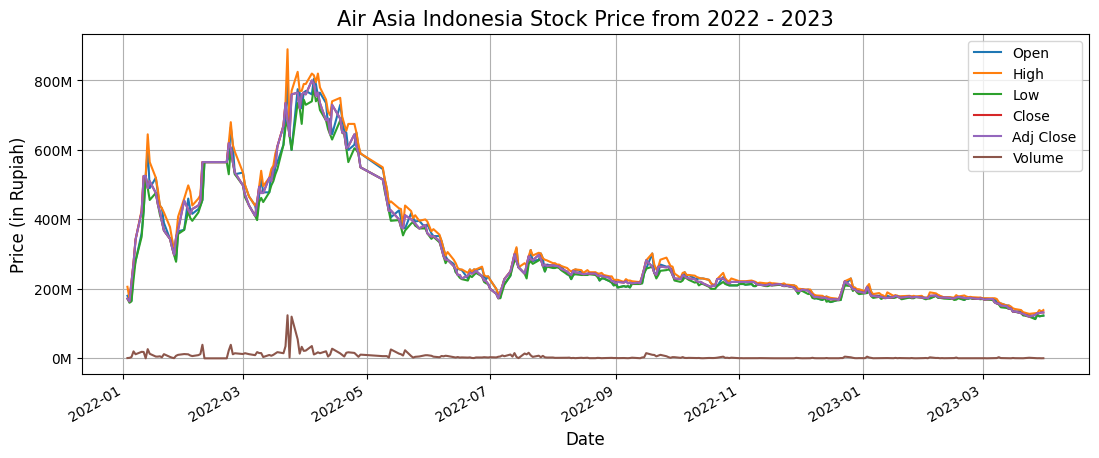

In [6]:
# Define the formatter function
def millions(x, pos):
    return '{:,.0f}M'.format(x/1e6)
# Visualize the historical prices from 2022 - 2023
df_cmpp['2022-01-01':].plot(figsize=(13,5))
plt.title('Air Asia Indonesia Stock Price from 2022 - 2023', fontsize=15)
plt.xlabel('Date', fontsize=12)
plt.ylabel('Price (in Rupiah)', fontsize=12)
plt.legend()
plt.grid(True)
plt.gca().yaxis.set_major_formatter(ticker.FuncFormatter(millions))
plt.show()

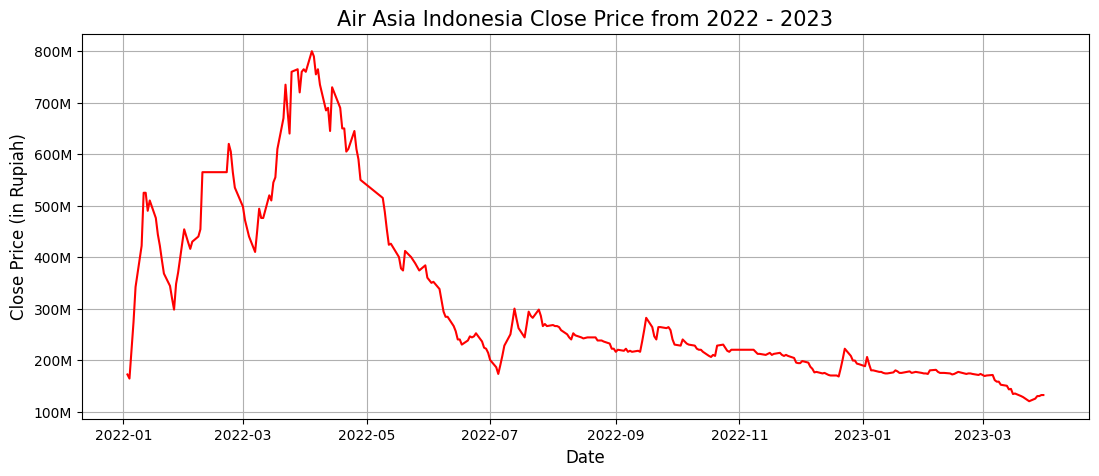

In [7]:
# Define the formatter function
def millions(x, pos):
    return '{:,.0f}M'.format(x/1e6)
# Visualize each of price attributes
plt.figure(figsize=(13,5))
plt.plot(df_cmpp['Close']['2022-01-01':], color='red')
plt.title('Air Asia Indonesia Close Price from 2022 - 2023', fontsize=15)
plt.xlabel('Date', fontsize=12)
plt.ylabel('Close Price (in Rupiah)', fontsize=12)
plt.grid(True)
plt.gca().yaxis.set_major_formatter(ticker.FuncFormatter(millions))
plt.show()

In [8]:
# Select the close price column as the target variable
target_col = 'Close'

# Create a new dataframe with only the target variable
target_df = pd.DataFrame(df_cmpp[target_col])

# Split the data into training and testing sets
train_size = int(len(target_df) * 0.9)
train_df = target_df[:train_size]
test_df = target_df[train_size:]
print('Training Set: ', train_df.shape)
print('Testing Set: ', test_df.shape)

Training Set:  (2682, 1)
Testing Set:  (298, 1)


In [9]:
# Scale the data using MinMaxScaler
scaler = MinMaxScaler(feature_range=(0, 1))
train_scaled = scaler.fit_transform(train_df)
test_scaled = scaler.transform(test_df)
print('Training Scaled: ', train_scaled[0:5], '\n')
print('Testing Scaled: ', test_scaled[0:5])

Training Scaled:  [[0.00273973]
 [0.00273973]
 [0.00273973]
 [0.00273973]
 [0.        ]] 

Testing Scaled:  [[0.30954058]
 [0.28596838]
 [0.26976249]
 [0.24913682]
 [0.2299844 ]]


In [10]:
# Define the sequence length and number of features
sequence_length = 60
num_features = 1

# Define the function to create sequences
def create_sequences(X, y, seq_length):
    X_sequences, y_sequences = [], []
    for i in range(seq_length, len(X)):
        X_sequences.append(X[i-seq_length:i, :])
        y_sequences.append(y[i, :])
    return np.array(X_sequences), np.array(y_sequences)

# Create training sequences and labels
X_train, y_train = create_sequences(train_scaled, train_scaled, sequence_length)

# Create testing sequences and labels
X_test, y_test = create_sequences(test_scaled, test_scaled, sequence_length)

# Print the shape of the training and testing sets
print('X train shape:', X_train.shape)
print('y train shape:', y_train.shape)
print('X test shape:', X_test.shape)
print('y test shape:', y_test.shape)

X train shape: (2622, 60, 1)
y train shape: (2622, 1)
X test shape: (238, 60, 1)
y test shape: (238, 1)


##### LSTM Network Default Model

In [11]:
# define the model
model = Sequential()
model.add(LSTM(32, input_shape=(sequence_length, num_features)))
model.add(Dense(1))

# compile the model
model.compile(loss='mean_squared_error')
# train the model
model.fit(X_train, y_train, epochs=10, 
          batch_size=100, verbose=1, validation_split=0.1)
model.summary()

Epoch 1/10
24/24 [==============================] - 4s 56ms/step - loss: 0.0095 - val_loss: 0.0010
Epoch 2/10
24/24 [==============================] - 1s 24ms/step - loss: 0.0024 - val_loss: 7.4265e-04
Epoch 3/10
24/24 [==============================] - 1s 24ms/step - loss: 0.0018 - val_loss: 6.6727e-04
Epoch 4/10
24/24 [==============================] - 1s 26ms/step - loss: 0.0015 - val_loss: 6.4905e-04
Epoch 5/10
24/24 [==============================] - 1s 25ms/step - loss: 0.0013 - val_loss: 5.9644e-04
Epoch 6/10
24/24 [==============================] - 1s 25ms/step - loss: 0.0012 - val_loss: 5.0955e-04
Epoch 7/10
24/24 [==============================] - 1s 25ms/step - loss: 0.0011 - val_loss: 5.8809e-04
Epoch 8/10
24/24 [==============================] - 1s 26ms/step - loss: 9.8449e-04 - val_loss: 4.2561e-04
Epoch 9/10
24/24 [==============================] - 1s 25ms/step - loss: 8.8570e-04 - val_loss: 4.1395e-04
Epoch 10/10
24/24 [==============================] - 1s 25ms/step - l

In [12]:
# Check evaluation metrics
y_pred = model.predict(X_test)
mape = round(metrics.mean_absolute_percentage_error(y_test, y_pred), 5)
mae = round(metrics.mean_absolute_error(y_test, y_pred), 7)
mse = round(metrics.mean_squared_error(y_test, y_pred), 7)
rmse = round(math.sqrt(mse), 5)
r2 = round(metrics.r2_score(y_test, y_pred), 6)
print('Mean Absolute Percentage Error (MAPE): ', mape)
print('Mean Absolute Error (MAE): ', mae)
print('Mean Squared Error (MSE): ', mse)
print('Root Mean Squared Error (RMSE): ', rmse)
print('R-Squared: ', r2)

8/8 [==============================] - 1s 6ms/step
Mean Absolute Percentage Error (MAPE):  0.061
Mean Absolute Error (MAE):  0.0087553
Mean Squared Error (MSE):  0.0001919
Root Mean Squared Error (RMSE):  0.01385
R-Squared:  0.967456


8/8 [==============================] - 0s 7ms/step


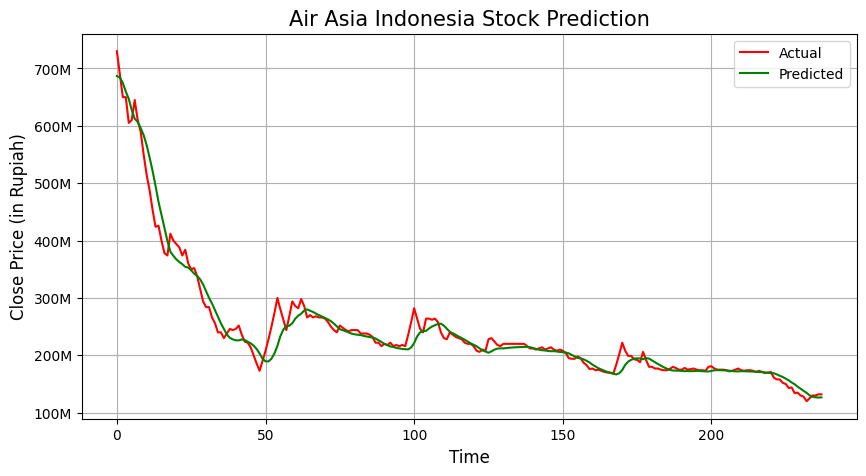

In [13]:
# Generate predictions
train_predict = model.predict(X_train)
test_predict = model.predict(X_test)
# Invert scaling for predictions
train_predict = scaler.inverse_transform(train_predict)
train_actual = scaler.inverse_transform(y_train)
test_predict = scaler.inverse_transform(test_predict)
test_actual = scaler.inverse_transform(y_test)

# Define the formatter function
def millions(x, pos):
    return '{:,.0f}M'.format(x/1e6)
# plot testing actual vs predicted values
plt.figure(figsize=(10,5))
plt.plot(test_actual, label='Actual', color='red')
plt.plot(test_predict, label='Predicted', color='green')
plt.title('Air Asia Indonesia Stock Prediction', fontsize=15)
plt.xlabel('Time', fontsize=12)
plt.ylabel('Close Price (in Rupiah)', fontsize=12)
plt.legend()
plt.grid(True)
plt.gca().yaxis.set_major_formatter(ticker.FuncFormatter(millions))
plt.show()

# Save the default model
model.save('models/cmpp_lstm_default.h5')

##### Linear - Adam

In [14]:
model = Sequential()
model.add(LSTM(128, input_shape=(sequence_length, num_features), return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(64))
model.add(Dropout(0.2))
model.add(Dense(32, activation='linear'))
model.add(Dense(1))

# compile the model
model.compile(loss='mean_squared_error', optimizer='adam')
# train the model
model.fit(X_train, y_train, epochs=10, batch_size=100, verbose=1, validation_split=0.1)
model.summary()

Epoch 1/10
24/24 [==============================] - 12s 245ms/step - loss: 0.0037 - val_loss: 7.3133e-04
Epoch 2/10
24/24 [==============================] - 5s 207ms/step - loss: 0.0014 - val_loss: 5.5941e-04
Epoch 3/10
24/24 [==============================] - 5s 198ms/step - loss: 0.0014 - val_loss: 7.2385e-04
Epoch 4/10
24/24 [==============================] - 5s 220ms/step - loss: 0.0015 - val_loss: 4.9744e-04
Epoch 5/10
24/24 [==============================] - 6s 264ms/step - loss: 0.0012 - val_loss: 4.3145e-04
Epoch 6/10
24/24 [==============================] - 8s 316ms/step - loss: 0.0011 - val_loss: 4.0131e-04
Epoch 7/10
24/24 [==============================] - 6s 229ms/step - loss: 9.1549e-04 - val_loss: 4.4571e-04
Epoch 8/10
24/24 [==============================] - 5s 219ms/step - loss: 0.0010 - val_loss: 4.3832e-04
Epoch 9/10
24/24 [==============================] - 5s 214ms/step - loss: 8.3977e-04 - val_loss: 3.0282e-04
Epoch 10/10
24/24 [==============================] - 5s

In [15]:
# Check evaluation metrics
y_pred = model.predict(X_test)
mape = round(metrics.mean_absolute_percentage_error(y_test, y_pred), 5)
mae = round(metrics.mean_absolute_error(y_test, y_pred), 7)
mse = round(metrics.mean_squared_error(y_test, y_pred), 7)
rmse = round(math.sqrt(mse), 5)
r2 = round(metrics.r2_score(y_test, y_pred), 6)
print('Mean Absolute Percentage Error (MAPE): ', mape)
print('Mean Absolute Error (MAE): ', mae)
print('Mean Squared Error (MSE): ', mse)
print('Root Mean Squared Error (RMSE): ', rmse)
print('R-Squared: ', r2)

8/8 [==============================] - 2s 28ms/step
Mean Absolute Percentage Error (MAPE):  0.07233
Mean Absolute Error (MAE):  0.0102721
Mean Squared Error (MSE):  0.0002383
Root Mean Squared Error (RMSE):  0.01544
R-Squared:  0.959602


8/8 [==============================] - 0s 28ms/step


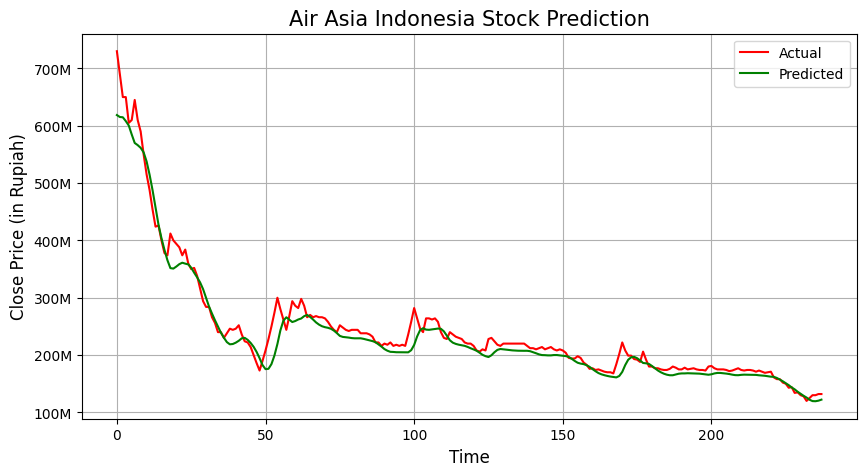

In [16]:
# Generate predictions
train_predict = model.predict(X_train)
test_predict = model.predict(X_test)
# Invert scaling for predictions
train_predict = scaler.inverse_transform(train_predict)
train_actual = scaler.inverse_transform(y_train)
test_predict = scaler.inverse_transform(test_predict)
test_actual = scaler.inverse_transform(y_test)

# Define the formatter function
def millions(x, pos):
    return '{:,.0f}M'.format(x/1e6)
# plot testing actual vs predicted values
plt.figure(figsize=(10,5))
plt.plot(test_actual, label='Actual', color='red')
plt.plot(test_predict, label='Predicted', color='green')
plt.title('Air Asia Indonesia Stock Prediction', fontsize=15)
plt.xlabel('Time', fontsize=12)
plt.ylabel('Close Price (in Rupiah)', fontsize=12)
plt.legend()
plt.grid(True)
plt.gca().yaxis.set_major_formatter(ticker.FuncFormatter(millions))
plt.show()

# Save the default model
model.save('models/cmpp_linear_adam.h5')

##### Linear - AdaGrad

In [17]:
model = Sequential()
model.add(LSTM(128, input_shape=(sequence_length, num_features), return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(64))
model.add(Dropout(0.2))
model.add(Dense(32, activation='linear'))
model.add(Dense(1))

# compile the model
model.compile(loss='mean_squared_error', optimizer='adagrad')
# train the model
model.fit(X_train, y_train, epochs=10, batch_size=100, verbose=1, validation_split=0.1)
model.summary()

Epoch 1/10
24/24 [==============================] - 14s 344ms/step - loss: 0.0168 - val_loss: 0.0016
Epoch 2/10
24/24 [==============================] - 6s 269ms/step - loss: 0.0128 - val_loss: 0.0011
Epoch 3/10
24/24 [==============================] - 8s 331ms/step - loss: 0.0119 - val_loss: 0.0011
Epoch 4/10
24/24 [==============================] - 9s 384ms/step - loss: 0.0116 - val_loss: 0.0011
Epoch 5/10
24/24 [==============================] - 9s 359ms/step - loss: 0.0114 - val_loss: 0.0011
Epoch 6/10
24/24 [==============================] - 8s 347ms/step - loss: 0.0113 - val_loss: 0.0011
Epoch 7/10
24/24 [==============================] - 7s 295ms/step - loss: 0.0109 - val_loss: 0.0011
Epoch 8/10
24/24 [==============================] - 7s 285ms/step - loss: 0.0110 - val_loss: 0.0011
Epoch 9/10
24/24 [==============================] - 7s 274ms/step - loss: 0.0104 - val_loss: 0.0010
Epoch 10/10
24/24 [==============================] - 7s 283ms/step - loss: 0.0103 - val_loss: 0.001

In [18]:
# Check evaluation metrics
y_pred = model.predict(X_test)
mape = round(metrics.mean_absolute_percentage_error(y_test, y_pred), 5)
mae = round(metrics.mean_absolute_error(y_test, y_pred), 7)
mse = round(metrics.mean_squared_error(y_test, y_pred), 7)
rmse = round(math.sqrt(mse), 5)
r2 = round(metrics.r2_score(y_test, y_pred), 6)
print('Mean Absolute Percentage Error (MAPE): ', mape)
print('Mean Absolute Error (MAE): ', mae)
print('Mean Squared Error (MSE): ', mse)
print('Root Mean Squared Error (RMSE): ', rmse)
print('R-Squared: ', r2)

8/8 [==============================] - 2s 32ms/step
Mean Absolute Percentage Error (MAPE):  0.26689
Mean Absolute Error (MAE):  0.0446372
Mean Squared Error (MSE):  0.0062084
Root Mean Squared Error (RMSE):  0.07879
R-Squared:  -0.052696


8/8 [==============================] - 0s 32ms/step


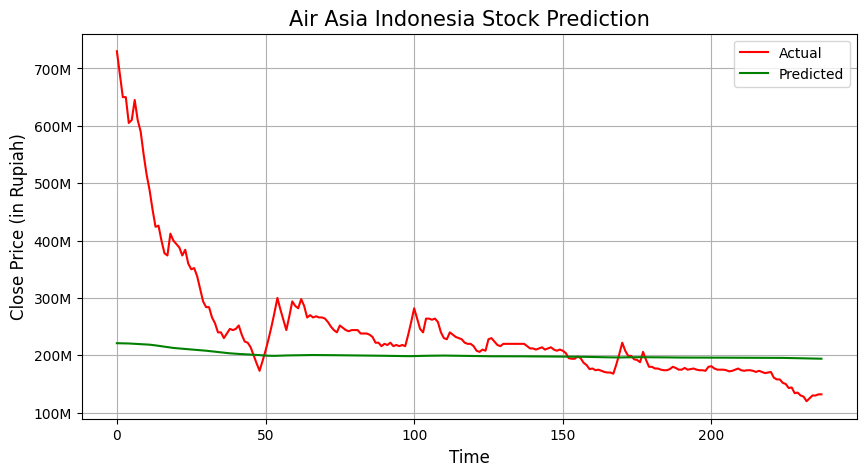

In [19]:
# Generate predictions
train_predict = model.predict(X_train)
test_predict = model.predict(X_test)
# Invert scaling for predictions
train_predict = scaler.inverse_transform(train_predict)
train_actual = scaler.inverse_transform(y_train)
test_predict = scaler.inverse_transform(test_predict)
test_actual = scaler.inverse_transform(y_test)

# Define the formatter function
def millions(x, pos):
    return '{:,.0f}M'.format(x/1e6)
# plot testing actual vs predicted values
plt.figure(figsize=(10,5))
plt.plot(test_actual, label='Actual', color='red')
plt.plot(test_predict, label='Predicted', color='green')
plt.title('Air Asia Indonesia Stock Prediction', fontsize=15)
plt.xlabel('Time', fontsize=12)
plt.ylabel('Close Price (in Rupiah)', fontsize=12)
plt.legend()
plt.grid(True)
plt.gca().yaxis.set_major_formatter(ticker.FuncFormatter(millions))
plt.show()
# Save the default model
model.save('models/cmpp_linear_adagrad.h5')

##### Linear - Nadam

In [20]:
model = Sequential()
model.add(LSTM(128, input_shape=(sequence_length, num_features), return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(64))
model.add(Dropout(0.2))
model.add(Dense(32, activation='linear'))
model.add(Dense(1))

# compile the model
model.compile(loss='mean_squared_error', optimizer='nadam')
# train the model
model.fit(X_train, y_train, epochs=10, batch_size=100, verbose=1, validation_split=0.1)
model.summary()

Epoch 1/10
24/24 [==============================] - 14s 287ms/step - loss: 0.0061 - val_loss: 8.5475e-04
Epoch 2/10
24/24 [==============================] - 6s 231ms/step - loss: 0.0019 - val_loss: 8.1745e-04
Epoch 3/10
24/24 [==============================] - 5s 228ms/step - loss: 0.0016 - val_loss: 6.1242e-04
Epoch 4/10
24/24 [==============================] - 5s 221ms/step - loss: 0.0014 - val_loss: 5.3762e-04
Epoch 5/10
24/24 [==============================] - 5s 223ms/step - loss: 0.0012 - val_loss: 5.3572e-04
Epoch 6/10
24/24 [==============================] - 5s 224ms/step - loss: 0.0012 - val_loss: 4.4859e-04
Epoch 7/10
24/24 [==============================] - 5s 220ms/step - loss: 0.0012 - val_loss: 4.0976e-04
Epoch 8/10
24/24 [==============================] - 5s 226ms/step - loss: 9.4359e-04 - val_loss: 3.7262e-04
Epoch 9/10
24/24 [==============================] - 5s 228ms/step - loss: 9.2949e-04 - val_loss: 4.3850e-04
Epoch 10/10
24/24 [==============================] - 5s

In [21]:
# Check evaluation metrics
y_pred = model.predict(X_test)
mape = round(metrics.mean_absolute_percentage_error(y_test, y_pred), 5)
mae = round(metrics.mean_absolute_error(y_test, y_pred), 7)
mse = round(metrics.mean_squared_error(y_test, y_pred), 7)
rmse = round(math.sqrt(mse), 5)
r2 = round(metrics.r2_score(y_test, y_pred), 6)
print('Mean Absolute Percentage Error (MAPE): ', mape)
print('Mean Absolute Error (MAE): ', mae)
print('Mean Squared Error (MSE): ', mse)
print('Root Mean Squared Error (RMSE): ', rmse)
print('R-Squared: ', r2)

8/8 [==============================] - 2s 29ms/step
Mean Absolute Percentage Error (MAPE):  0.07609
Mean Absolute Error (MAE):  0.011916
Mean Squared Error (MSE):  0.0004162
Root Mean Squared Error (RMSE):  0.0204
R-Squared:  0.929425


8/8 [==============================] - 0s 30ms/step


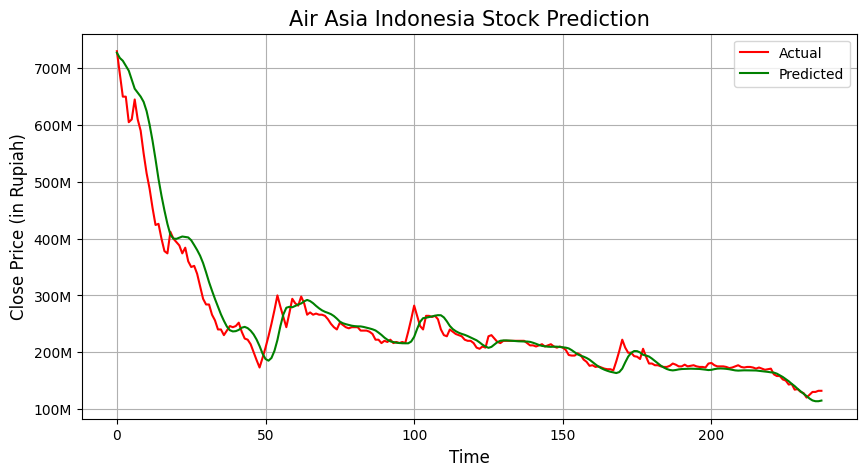

In [22]:
# Generate predictions
train_predict = model.predict(X_train)
test_predict = model.predict(X_test)
# Invert scaling for predictions
train_predict = scaler.inverse_transform(train_predict)
train_actual = scaler.inverse_transform(y_train)
test_predict = scaler.inverse_transform(test_predict)
test_actual = scaler.inverse_transform(y_test)

# Define the formatter function
def millions(x, pos):
    return '{:,.0f}M'.format(x/1e6)
# plot testing actual vs predicted values
plt.figure(figsize=(10,5))
plt.plot(test_actual, label='Actual', color='red')
plt.plot(test_predict, label='Predicted', color='green')
plt.title('Air Asia Indonesia Stock Prediction', fontsize=15)
plt.xlabel('Time', fontsize=12)
plt.ylabel('Close Price (in Rupiah)', fontsize=12)
plt.legend()
plt.grid(True)
plt.gca().yaxis.set_major_formatter(ticker.FuncFormatter(millions))
plt.show()
# Save the default model
model.save('models/cmpp_linear_nadam.h5')

#### Linear - RMSProp

In [23]:
model = Sequential()
model.add(LSTM(128, input_shape=(sequence_length, num_features), return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(64))
model.add(Dropout(0.2))
model.add(Dense(32, activation='linear'))
model.add(Dense(1))

# compile the model
model.compile(loss='mean_squared_error', optimizer='rmsprop')
# train the model
model.fit(X_train, y_train, epochs=10, batch_size=100, verbose=1, validation_split=0.1)
model.summary()

Epoch 1/10
24/24 [==============================] - 13s 307ms/step - loss: 0.0048 - val_loss: 0.0047
Epoch 2/10
24/24 [==============================] - 5s 212ms/step - loss: 0.0027 - val_loss: 0.0016
Epoch 3/10
24/24 [==============================] - 5s 209ms/step - loss: 0.0024 - val_loss: 7.0416e-04
Epoch 4/10
24/24 [==============================] - 5s 214ms/step - loss: 0.0020 - val_loss: 6.3530e-04
Epoch 5/10
24/24 [==============================] - 5s 216ms/step - loss: 0.0018 - val_loss: 0.0017
Epoch 6/10
24/24 [==============================] - 5s 215ms/step - loss: 0.0017 - val_loss: 5.8789e-04
Epoch 7/10
24/24 [==============================] - 5s 218ms/step - loss: 0.0015 - val_loss: 5.5136e-04
Epoch 8/10
24/24 [==============================] - 5s 226ms/step - loss: 0.0015 - val_loss: 5.8740e-04
Epoch 9/10
24/24 [==============================] - 5s 224ms/step - loss: 0.0015 - val_loss: 5.1870e-04
Epoch 10/10
24/24 [==============================] - 5s 223ms/step - loss: 

In [24]:
# Check evaluation metrics
y_pred = model.predict(X_test)
mape = round(metrics.mean_absolute_percentage_error(y_test, y_pred), 5)
mae = round(metrics.mean_absolute_error(y_test, y_pred), 7)
mse = round(metrics.mean_squared_error(y_test, y_pred), 7)
rmse = round(math.sqrt(mse), 5)
r2 = round(metrics.r2_score(y_test, y_pred), 6)
print('Mean Absolute Percentage Error (MAPE): ', mape)
print('Mean Absolute Error (MAE): ', mae)
print('Mean Squared Error (MSE): ', mse)
print('Root Mean Squared Error (RMSE): ', rmse)
print('R-Squared: ', r2)

8/8 [==============================] - 2s 29ms/step
Mean Absolute Percentage Error (MAPE):  0.16805
Mean Absolute Error (MAE):  0.0205386
Mean Squared Error (MSE):  0.0006088
Root Mean Squared Error (RMSE):  0.02467
R-Squared:  0.896766


8/8 [==============================] - 0s 29ms/step


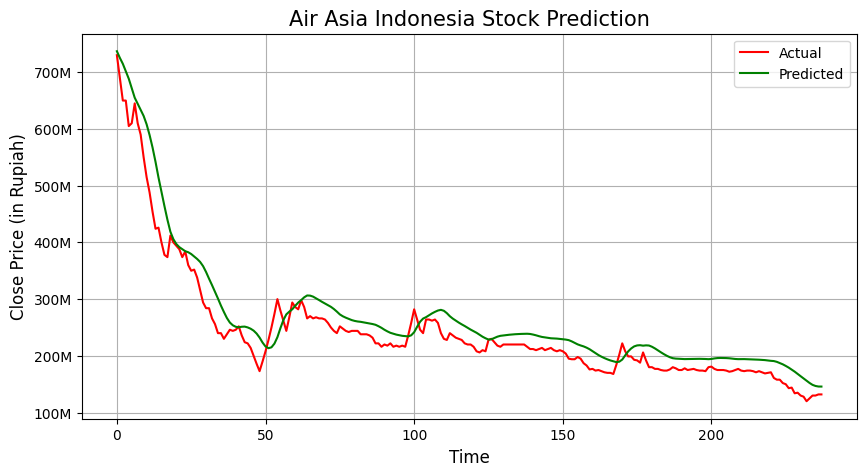

In [25]:
# Generate predictions
train_predict = model.predict(X_train)
test_predict = model.predict(X_test)
# Invert scaling for predictions
train_predict = scaler.inverse_transform(train_predict)
train_actual = scaler.inverse_transform(y_train)
test_predict = scaler.inverse_transform(test_predict)
test_actual = scaler.inverse_transform(y_test)

# Define the formatter function
def millions(x, pos):
    return '{:,.0f}M'.format(x/1e6)
# plot testing actual vs predicted values
plt.figure(figsize=(10,5))
plt.plot(test_actual, label='Actual', color='red')
plt.plot(test_predict, label='Predicted', color='green')
plt.title('Air Asia Indonesia Stock Prediction', fontsize=15)
plt.xlabel('Time', fontsize=12)
plt.ylabel('Close Price (in Rupiah)', fontsize=12)
plt.legend()
plt.grid(True)
plt.gca().yaxis.set_major_formatter(ticker.FuncFormatter(millions))
plt.show()
# Save the default model
model.save('models/cmpp_linear_rmsprop.h5')

##### Linear - AdaDelta

In [26]:
model = Sequential()
model.add(LSTM(128, input_shape=(sequence_length, num_features), return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(64))
model.add(Dropout(0.2))
model.add(Dense(32, activation='linear'))
model.add(Dense(1))

# compile the model
model.compile(loss='mean_squared_error', optimizer='adadelta')
# train the model
model.fit(X_train, y_train, epochs=10, batch_size=100, verbose=1, validation_split=0.1)
model.summary()

Epoch 1/10
24/24 [==============================] - 15s 378ms/step - loss: 0.0243 - val_loss: 0.0120
Epoch 2/10
24/24 [==============================] - 7s 283ms/step - loss: 0.0240 - val_loss: 0.0117
Epoch 3/10
24/24 [==============================] - 7s 285ms/step - loss: 0.0236 - val_loss: 0.0114
Epoch 4/10
24/24 [==============================] - 7s 285ms/step - loss: 0.0231 - val_loss: 0.0111
Epoch 5/10
24/24 [==============================] - 7s 291ms/step - loss: 0.0227 - val_loss: 0.0108
Epoch 6/10
24/24 [==============================] - 8s 320ms/step - loss: 0.0223 - val_loss: 0.0105
Epoch 7/10
24/24 [==============================] - 7s 293ms/step - loss: 0.0222 - val_loss: 0.0102
Epoch 8/10
24/24 [==============================] - 7s 292ms/step - loss: 0.0215 - val_loss: 0.0099
Epoch 9/10
24/24 [==============================] - 7s 291ms/step - loss: 0.0213 - val_loss: 0.0096
Epoch 10/10
24/24 [==============================] - 8s 315ms/step - loss: 0.0210 - val_loss: 0.009

In [27]:
# Check evaluation metrics
y_pred = model.predict(X_test)
mape = round(metrics.mean_absolute_percentage_error(y_test, y_pred), 5)
mae = round(metrics.mean_absolute_error(y_test, y_pred), 7)
mse = round(metrics.mean_squared_error(y_test, y_pred), 7)
rmse = round(math.sqrt(mse), 5)
r2 = round(metrics.r2_score(y_test, y_pred), 6)
print('Mean Absolute Percentage Error (MAPE): ', mape)
print('Mean Absolute Error (MAE): ', mae)
print('Mean Squared Error (MSE): ', mse)
print('Root Mean Squared Error (RMSE): ', rmse)
print('R-Squared: ', r2)

8/8 [==============================] - 2s 36ms/step
Mean Absolute Percentage Error (MAPE):  0.93961
Mean Absolute Error (MAE):  0.1319192
Mean Squared Error (MSE):  0.0238396
Root Mean Squared Error (RMSE):  0.1544
R-Squared:  -3.042213


8/8 [==============================] - 0s 33ms/step


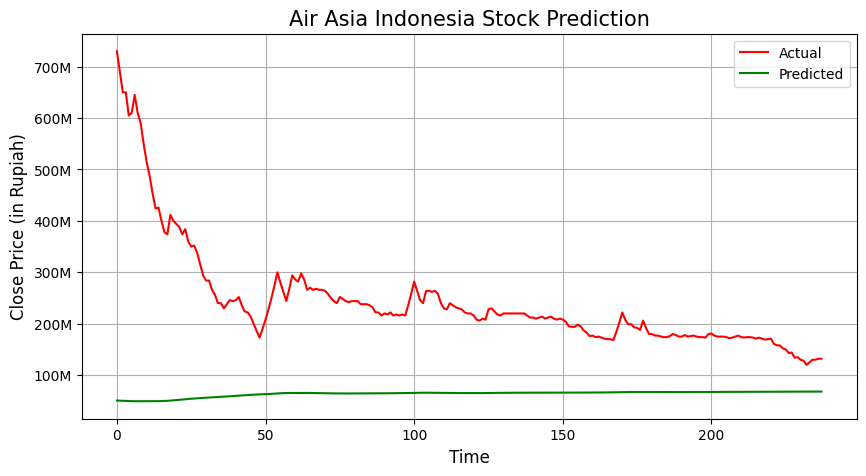

In [28]:
# Generate predictions
train_predict = model.predict(X_train)
test_predict = model.predict(X_test)
# Invert scaling for predictions
train_predict = scaler.inverse_transform(train_predict)
train_actual = scaler.inverse_transform(y_train)
test_predict = scaler.inverse_transform(test_predict)
test_actual = scaler.inverse_transform(y_test)

# Define the formatter function
def millions(x, pos):
    return '{:,.0f}M'.format(x/1e6)
# plot testing actual vs predicted values
plt.figure(figsize=(10,5))
plt.plot(test_actual, label='Actual', color='red')
plt.plot(test_predict, label='Predicted', color='green')
plt.title('Air Asia Indonesia Stock Prediction', fontsize=15)
plt.xlabel('Time', fontsize=12)
plt.ylabel('Close Price (in Rupiah)', fontsize=12)
plt.legend()
plt.grid(True)
plt.gca().yaxis.set_major_formatter(ticker.FuncFormatter(millions))
plt.show()
# Save the default model
model.save('models/cmpp_linear_adadelta.h5')

##### Linear - SGD

In [29]:
model = Sequential()
model.add(LSTM(128, input_shape=(sequence_length, num_features), return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(64))
model.add(Dropout(0.2))
model.add(Dense(32, activation='linear'))
model.add(Dense(1))

# compile the model
model.compile(loss='mean_squared_error', optimizer='sgd')
# train the model
model.fit(X_train, y_train, epochs=10, batch_size=100, verbose=1, validation_split=0.1)
model.summary()

Epoch 1/10
24/24 [==============================] - 15s 404ms/step - loss: 0.0120 - val_loss: 0.0011
Epoch 2/10
24/24 [==============================] - 7s 300ms/step - loss: 0.0102 - val_loss: 0.0011
Epoch 3/10
24/24 [==============================] - 8s 323ms/step - loss: 0.0096 - val_loss: 0.0011
Epoch 4/10
24/24 [==============================] - 8s 322ms/step - loss: 0.0092 - val_loss: 0.0010
Epoch 5/10
24/24 [==============================] - 8s 318ms/step - loss: 0.0086 - val_loss: 0.0010
Epoch 6/10
24/24 [==============================] - 8s 325ms/step - loss: 0.0079 - val_loss: 0.0010
Epoch 7/10
24/24 [==============================] - 8s 335ms/step - loss: 0.0077 - val_loss: 0.0010
Epoch 8/10
24/24 [==============================] - 8s 325ms/step - loss: 0.0073 - val_loss: 9.8650e-04
Epoch 9/10
24/24 [==============================] - 8s 319ms/step - loss: 0.0071 - val_loss: 9.7869e-04
Epoch 10/10
24/24 [==============================] - 8s 327ms/step - loss: 0.0064 - val_los

In [30]:
# Check evaluation metrics
y_pred = model.predict(X_test)
mape = round(metrics.mean_absolute_percentage_error(y_test, y_pred), 5)
mae = round(metrics.mean_absolute_error(y_test, y_pred), 7)
mse = round(metrics.mean_squared_error(y_test, y_pred), 7)
rmse = round(math.sqrt(mse), 5)
r2 = round(metrics.r2_score(y_test, y_pred), 6)
print('Mean Absolute Percentage Error (MAPE): ', mape)
print('Mean Absolute Error (MAE): ', mae)
print('Mean Squared Error (MSE): ', mse)
print('Root Mean Squared Error (RMSE): ', rmse)
print('R-Squared: ', r2)

8/8 [==============================] - 2s 40ms/step
Mean Absolute Percentage Error (MAPE):  0.19471
Mean Absolute Error (MAE):  0.0278993
Mean Squared Error (MSE):  0.0023876
Root Mean Squared Error (RMSE):  0.04886
R-Squared:  0.595167


8/8 [==============================] - 0s 34ms/step


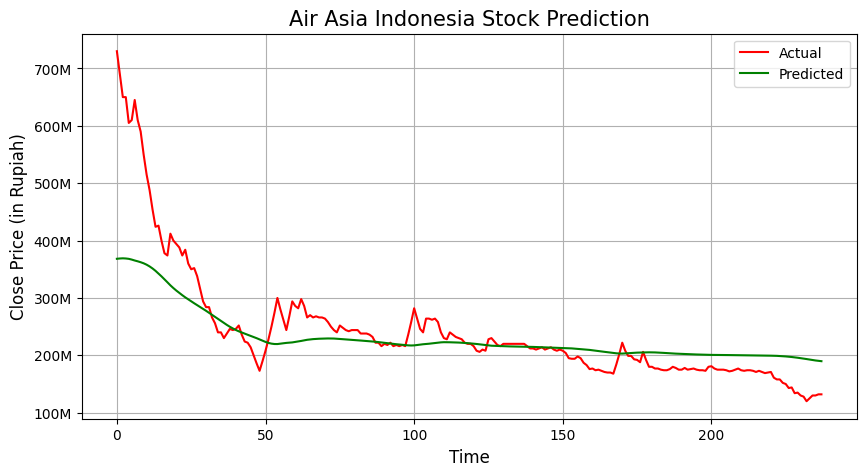

In [31]:
# Generate predictions
train_predict = model.predict(X_train)
test_predict = model.predict(X_test)
# Invert scaling for predictions
train_predict = scaler.inverse_transform(train_predict)
train_actual = scaler.inverse_transform(y_train)
test_predict = scaler.inverse_transform(test_predict)
test_actual = scaler.inverse_transform(y_test)

# Define the formatter function
def millions(x, pos):
    return '{:,.0f}M'.format(x/1e6)
# plot testing actual vs predicted values
plt.figure(figsize=(10,5))
plt.plot(test_actual, label='Actual', color='red')
plt.plot(test_predict, label='Predicted', color='green')
plt.title('Air Asia Indonesia Stock Prediction', fontsize=15)
plt.xlabel('Time', fontsize=12)
plt.ylabel('Close Price (in Rupiah)', fontsize=12)
plt.legend()
plt.grid(True)
plt.gca().yaxis.set_major_formatter(ticker.FuncFormatter(millions))
plt.show()
# Save the default model
model.save('models/cmpp_linear_sgd.h5')

#### Linear - Adamax

In [32]:
model = Sequential()
model.add(LSTM(128, input_shape=(sequence_length, num_features), return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(64))
model.add(Dropout(0.2))
model.add(Dense(32, activation='linear'))
model.add(Dense(1))

# compile the model
model.compile(loss='mean_squared_error', optimizer='adamax')
# train the model
model.fit(X_train, y_train, epochs=10, batch_size=100, verbose=1, validation_split=0.1)
model.summary()

Epoch 1/10
24/24 [==============================] - 13s 280ms/step - loss: 0.0038 - val_loss: 7.6988e-04
Epoch 2/10
24/24 [==============================] - 5s 211ms/step - loss: 0.0018 - val_loss: 7.3717e-04
Epoch 3/10
24/24 [==============================] - 5s 225ms/step - loss: 0.0017 - val_loss: 7.3326e-04
Epoch 4/10
24/24 [==============================] - 6s 232ms/step - loss: 0.0016 - val_loss: 7.7335e-04
Epoch 5/10
24/24 [==============================] - 6s 236ms/step - loss: 0.0014 - val_loss: 7.5268e-04
Epoch 6/10
24/24 [==============================] - 5s 223ms/step - loss: 0.0014 - val_loss: 6.1283e-04
Epoch 7/10
24/24 [==============================] - 5s 224ms/step - loss: 0.0016 - val_loss: 6.0062e-04
Epoch 8/10
24/24 [==============================] - 5s 228ms/step - loss: 0.0013 - val_loss: 5.6829e-04
Epoch 9/10
24/24 [==============================] - 5s 225ms/step - loss: 0.0013 - val_loss: 5.4881e-04
Epoch 10/10
24/24 [==============================] - 6s 230ms/s

In [33]:
# Check evaluation metrics
y_pred = model.predict(X_test)
mape = round(metrics.mean_absolute_percentage_error(y_test, y_pred), 5)
mae = round(metrics.mean_absolute_error(y_test, y_pred), 7)
mse = round(metrics.mean_squared_error(y_test, y_pred), 7)
rmse = round(math.sqrt(mse), 5)
r2 = round(metrics.r2_score(y_test, y_pred), 6)
print('Mean Absolute Percentage Error (MAPE): ', mape)
print('Mean Absolute Error (MAE): ', mae)
print('Mean Squared Error (MSE): ', mse)
print('Root Mean Squared Error (RMSE): ', rmse)
print('R-Squared: ', r2)

8/8 [==============================] - 2s 32ms/step
Mean Absolute Percentage Error (MAPE):  0.08757
Mean Absolute Error (MAE):  0.0119742
Mean Squared Error (MSE):  0.0003168
Root Mean Squared Error (RMSE):  0.0178
R-Squared:  0.946287


8/8 [==============================] - 0s 39ms/step


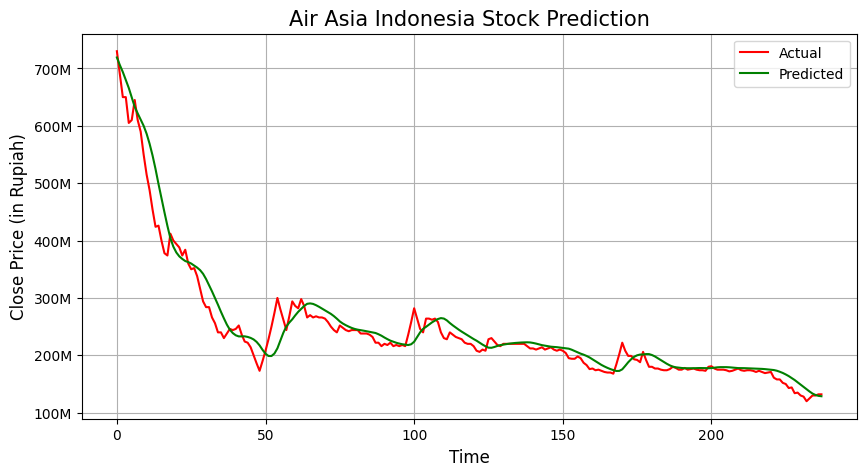

In [34]:
# Generate predictions
train_predict = model.predict(X_train)
test_predict = model.predict(X_test)
# Invert scaling for predictions
train_predict = scaler.inverse_transform(train_predict)
train_actual = scaler.inverse_transform(y_train)
test_predict = scaler.inverse_transform(test_predict)
test_actual = scaler.inverse_transform(y_test)

# Define the formatter function
def millions(x, pos):
    return '{:,.0f}M'.format(x/1e6)
# plot testing actual vs predicted values
plt.figure(figsize=(10,5))
plt.plot(test_actual, label='Actual', color='red')
plt.plot(test_predict, label='Predicted', color='green')
plt.title('Air Asia Indonesia Stock Prediction', fontsize=15)
plt.xlabel('Time', fontsize=12)
plt.ylabel('Close Price (in Rupiah)', fontsize=12)
plt.legend()
plt.grid(True)
plt.gca().yaxis.set_major_formatter(ticker.FuncFormatter(millions))
plt.show()
# Save the default model
model.save('models/cmpp_linear_adamax.h5')

##### ReLU - Adam

In [35]:
model = Sequential()
model.add(LSTM(128, input_shape=(sequence_length, num_features), return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(64))
model.add(Dropout(0.2))
model.add(Dense(32, activation='relu'))
model.add(Dense(1))

# compile the model
model.compile(loss='mean_squared_error', optimizer='adam')
# train the model
model.fit(X_train, y_train, epochs=10, batch_size=100, verbose=1, validation_split=0.1)
model.summary()

Epoch 1/10
24/24 [==============================] - 13s 273ms/step - loss: 0.0051 - val_loss: 0.0010
Epoch 2/10
24/24 [==============================] - 5s 206ms/step - loss: 0.0017 - val_loss: 6.2154e-04
Epoch 3/10
24/24 [==============================] - 5s 204ms/step - loss: 0.0018 - val_loss: 6.1372e-04
Epoch 4/10
24/24 [==============================] - 5s 227ms/step - loss: 0.0015 - val_loss: 0.0013
Epoch 5/10
24/24 [==============================] - 5s 227ms/step - loss: 0.0013 - val_loss: 4.8585e-04
Epoch 6/10
24/24 [==============================] - 5s 218ms/step - loss: 0.0012 - val_loss: 5.1182e-04
Epoch 7/10
24/24 [==============================] - 5s 214ms/step - loss: 0.0011 - val_loss: 4.4963e-04
Epoch 8/10
24/24 [==============================] - 5s 215ms/step - loss: 9.3441e-04 - val_loss: 3.9222e-04
Epoch 9/10
24/24 [==============================] - 5s 215ms/step - loss: 8.9926e-04 - val_loss: 4.9820e-04
Epoch 10/10
24/24 [==============================] - 5s 216ms/s

In [36]:
# Check evaluation metrics
y_pred = model.predict(X_test)
mape = round(metrics.mean_absolute_percentage_error(y_test, y_pred), 5)
mae = round(metrics.mean_absolute_error(y_test, y_pred), 7)
mse = round(metrics.mean_squared_error(y_test, y_pred), 7)
rmse = round(math.sqrt(mse), 5)
r2 = round(metrics.r2_score(y_test, y_pred), 6)
print('Mean Absolute Percentage Error (MAPE): ', mape)
print('Mean Absolute Error (MAE): ', mae)
print('Mean Squared Error (MSE): ', mse)
print('Root Mean Squared Error (RMSE): ', rmse)
print('R-Squared: ', r2)

8/8 [==============================] - 2s 31ms/step
Mean Absolute Percentage Error (MAPE):  0.05981
Mean Absolute Error (MAE):  0.0086075
Mean Squared Error (MSE):  0.0001926
Root Mean Squared Error (RMSE):  0.01388
R-Squared:  0.967346


8/8 [==============================] - 0s 37ms/step


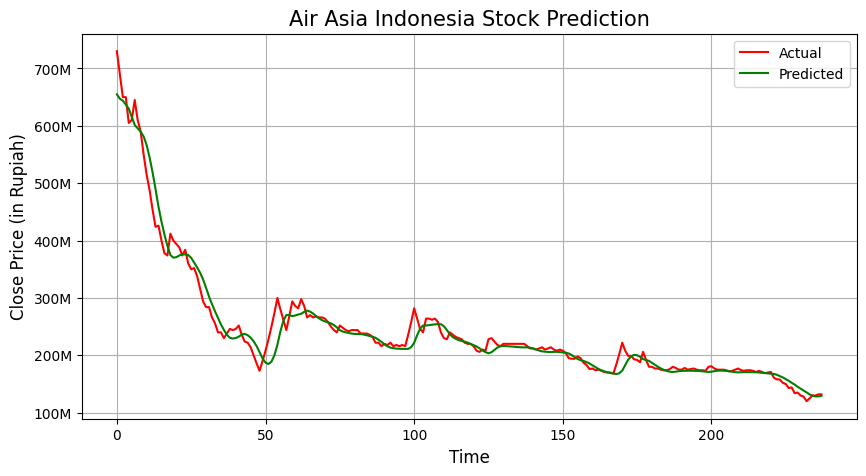

In [37]:
# Generate predictions
train_predict = model.predict(X_train)
test_predict = model.predict(X_test)
# Invert scaling for predictions
train_predict = scaler.inverse_transform(train_predict)
train_actual = scaler.inverse_transform(y_train)
test_predict = scaler.inverse_transform(test_predict)
test_actual = scaler.inverse_transform(y_test)

# Define the formatter function
def millions(x, pos):
    return '{:,.0f}M'.format(x/1e6)
# plot testing actual vs predicted values
plt.figure(figsize=(10,5))
plt.plot(test_actual, label='Actual', color='red')
plt.plot(test_predict, label='Predicted', color='green')
plt.title('Air Asia Indonesia Stock Prediction', fontsize=15)
plt.xlabel('Time', fontsize=12)
plt.ylabel('Close Price (in Rupiah)', fontsize=12)
plt.legend()
plt.grid(True)
plt.gca().yaxis.set_major_formatter(ticker.FuncFormatter(millions))
plt.show()
# Save the default model
model.save('models/cmpp_relu_adam.h5')

#### ReLU - AdaGrad

In [38]:
model = Sequential()
model.add(LSTM(128, input_shape=(sequence_length, num_features), return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(64))
model.add(Dropout(0.2))
model.add(Dense(32, activation='relu'))
model.add(Dense(1))

# compile the model
model.compile(loss='mean_squared_error', optimizer='adagrad')
# train the model
model.fit(X_train, y_train, epochs=10, batch_size=100, verbose=1, validation_split=0.1)
model.summary()

Epoch 1/10
24/24 [==============================] - 12s 268ms/step - loss: 0.0159 - val_loss: 0.0040
Epoch 2/10
24/24 [==============================] - 13s 550ms/step - loss: 0.0122 - val_loss: 0.0021
Epoch 3/10
24/24 [==============================] - 14s 590ms/step - loss: 0.0108 - val_loss: 0.0014
Epoch 4/10
24/24 [==============================] - 14s 581ms/step - loss: 0.0100 - val_loss: 0.0011
Epoch 5/10
24/24 [==============================] - 14s 588ms/step - loss: 0.0097 - val_loss: 0.0011
Epoch 6/10
24/24 [==============================] - 14s 585ms/step - loss: 0.0096 - val_loss: 0.0010
Epoch 7/10
24/24 [==============================] - 15s 608ms/step - loss: 0.0094 - val_loss: 0.0010
Epoch 8/10
24/24 [==============================] - 14s 590ms/step - loss: 0.0091 - val_loss: 0.0010
Epoch 9/10
24/24 [==============================] - 14s 581ms/step - loss: 0.0092 - val_loss: 0.0010
Epoch 10/10
24/24 [==============================] - 14s 591ms/step - loss: 0.0091 - val_lo

In [39]:
# Check evaluation metrics
y_pred = model.predict(X_test)
mape = round(metrics.mean_absolute_percentage_error(y_test, y_pred), 5)
mae = round(metrics.mean_absolute_error(y_test, y_pred), 7)
mse = round(metrics.mean_squared_error(y_test, y_pred), 7)
rmse = round(math.sqrt(mse), 5)
r2 = round(metrics.r2_score(y_test, y_pred), 6)
print('Mean Absolute Percentage Error (MAPE): ', mape)
print('Mean Absolute Error (MAE): ', mae)
print('Mean Squared Error (MSE): ', mse)
print('Root Mean Squared Error (RMSE): ', rmse)
print('R-Squared: ', r2)

8/8 [==============================] - 2s 45ms/step
Mean Absolute Percentage Error (MAPE):  0.23898
Mean Absolute Error (MAE):  0.0405869
Mean Squared Error (MSE):  0.0051531
Root Mean Squared Error (RMSE):  0.07179
R-Squared:  0.126247


8/8 [==============================] - 0s 46ms/step


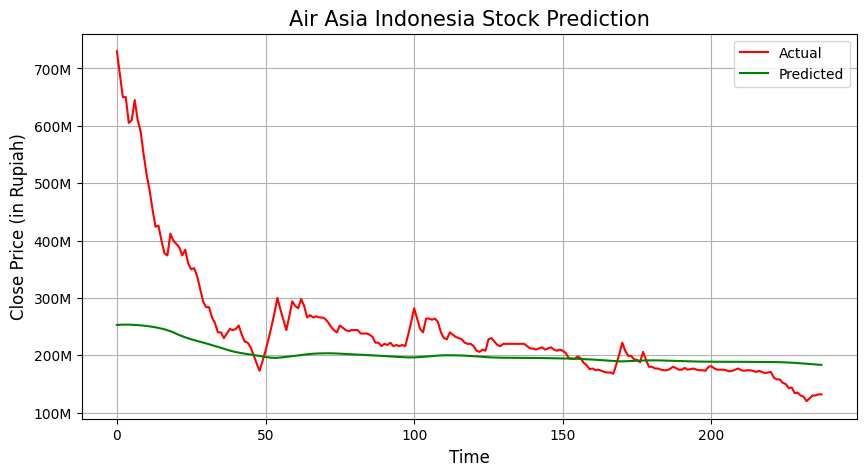

In [40]:
# Generate predictions
train_predict = model.predict(X_train)
test_predict = model.predict(X_test)
# Invert scaling for predictions
train_predict = scaler.inverse_transform(train_predict)
train_actual = scaler.inverse_transform(y_train)
test_predict = scaler.inverse_transform(test_predict)
test_actual = scaler.inverse_transform(y_test)

# Define the formatter function
def millions(x, pos):
    return '{:,.0f}M'.format(x/1e6)
# plot testing actual vs predicted values
plt.figure(figsize=(10,5))
plt.plot(test_actual, label='Actual', color='red')
plt.plot(test_predict, label='Predicted', color='green')
plt.title('Air Asia Indonesia Stock Prediction', fontsize=15)
plt.xlabel('Time', fontsize=12)
plt.ylabel('Close Price (in Rupiah)', fontsize=12)
plt.legend()
plt.grid(True)
plt.gca().yaxis.set_major_formatter(ticker.FuncFormatter(millions))
plt.show()
# Save the default model
model.save('models/cmpp_relu_adagrad.h5')

##### ReLU - Nadam

In [41]:
model = Sequential()
model.add(LSTM(128, input_shape=(sequence_length, num_features), return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(64))
model.add(Dropout(0.2))
model.add(Dense(32, activation='relu'))
model.add(Dense(1))

# compile the model
model.compile(loss='mean_squared_error', optimizer='nadam')
# train the model
model.fit(X_train, y_train, epochs=10, batch_size=100, verbose=1, validation_split=0.1)
model.summary()

Epoch 1/10
24/24 [==============================] - 20s 533ms/step - loss: 0.0071 - val_loss: 8.7478e-04
Epoch 2/10
24/24 [==============================] - 10s 414ms/step - loss: 0.0020 - val_loss: 8.3725e-04
Epoch 3/10
24/24 [==============================] - 10s 418ms/step - loss: 0.0017 - val_loss: 7.2971e-04
Epoch 4/10
24/24 [==============================] - 10s 423ms/step - loss: 0.0016 - val_loss: 6.3350e-04
Epoch 5/10
24/24 [==============================] - 10s 433ms/step - loss: 0.0013 - val_loss: 8.6599e-04
Epoch 6/10
24/24 [==============================] - 10s 420ms/step - loss: 0.0013 - val_loss: 5.6552e-04
Epoch 7/10
24/24 [==============================] - 11s 448ms/step - loss: 0.0012 - val_loss: 5.2554e-04
Epoch 8/10
24/24 [==============================] - 10s 425ms/step - loss: 0.0010 - val_loss: 5.0633e-04
Epoch 9/10
24/24 [==============================] - 10s 425ms/step - loss: 0.0011 - val_loss: 4.7003e-04
Epoch 10/10
24/24 [==============================] - 10

In [42]:
# Check evaluation metrics
y_pred = model.predict(X_test)
mape = round(metrics.mean_absolute_percentage_error(y_test, y_pred), 5)
mae = round(metrics.mean_absolute_error(y_test, y_pred), 7)
mse = round(metrics.mean_squared_error(y_test, y_pred), 7)
rmse = round(math.sqrt(mse), 5)
r2 = round(metrics.r2_score(y_test, y_pred), 6)
print('Mean Absolute Percentage Error (MAPE): ', mape)
print('Mean Absolute Error (MAE): ', mae)
print('Mean Squared Error (MSE): ', mse)
print('Root Mean Squared Error (RMSE): ', rmse)
print('R-Squared: ', r2)

8/8 [==============================] - 2s 40ms/step
Mean Absolute Percentage Error (MAPE):  0.07147
Mean Absolute Error (MAE):  0.0115846
Mean Squared Error (MSE):  0.0004407
Root Mean Squared Error (RMSE):  0.02099
R-Squared:  0.925278


8/8 [==============================] - 0s 42ms/step


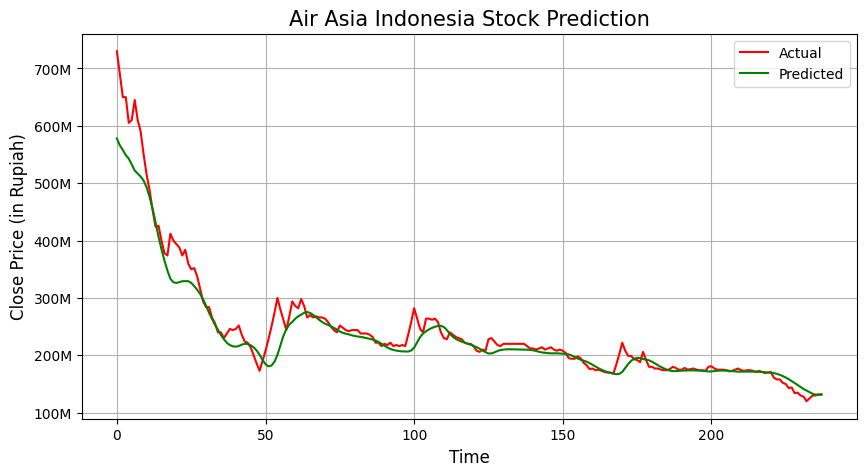

In [43]:
# Generate predictions
train_predict = model.predict(X_train)
test_predict = model.predict(X_test)
# Invert scaling for predictions
train_predict = scaler.inverse_transform(train_predict)
train_actual = scaler.inverse_transform(y_train)
test_predict = scaler.inverse_transform(test_predict)
test_actual = scaler.inverse_transform(y_test)

# Define the formatter function
def millions(x, pos):
    return '{:,.0f}M'.format(x/1e6)
# plot testing actual vs predicted values
plt.figure(figsize=(10,5))
plt.plot(test_actual, label='Actual', color='red')
plt.plot(test_predict, label='Predicted', color='green')
plt.title('Air Asia Indonesia Stock Prediction', fontsize=15)
plt.xlabel('Time', fontsize=12)
plt.ylabel('Close Price (in Rupiah)', fontsize=12)
plt.legend()
plt.grid(True)
plt.gca().yaxis.set_major_formatter(ticker.FuncFormatter(millions))
plt.show()
# Save the default model
model.save('models/cmpp_relu_nadam.h5')

##### ReLU - RMSProp

In [44]:
model = Sequential()
model.add(LSTM(128, input_shape=(sequence_length, num_features), return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(64))
model.add(Dropout(0.2))
model.add(Dense(32, activation='relu'))
model.add(Dense(1))

# compile the model
model.compile(loss='mean_squared_error', optimizer='rmsprop')
# train the model
model.fit(X_train, y_train, epochs=10, batch_size=100, verbose=1, validation_split=0.1)
model.summary()

Epoch 1/10
24/24 [==============================] - 21s 623ms/step - loss: 0.0052 - val_loss: 8.2316e-04
Epoch 2/10
24/24 [==============================] - 14s 598ms/step - loss: 0.0028 - val_loss: 7.8395e-04
Epoch 3/10
24/24 [==============================] - 14s 580ms/step - loss: 0.0022 - val_loss: 8.7032e-04
Epoch 4/10
24/24 [==============================] - 14s 588ms/step - loss: 0.0020 - val_loss: 9.8834e-04
Epoch 5/10
24/24 [==============================] - 14s 589ms/step - loss: 0.0021 - val_loss: 6.9193e-04
Epoch 6/10
24/24 [==============================] - 19s 787ms/step - loss: 0.0018 - val_loss: 6.3028e-04
Epoch 7/10
24/24 [==============================] - 18s 738ms/step - loss: 0.0016 - val_loss: 6.5327e-04
Epoch 8/10
24/24 [==============================] - 16s 692ms/step - loss: 0.0016 - val_loss: 7.8282e-04
Epoch 9/10
24/24 [==============================] - 17s 693ms/step - loss: 0.0014 - val_loss: 6.4594e-04
Epoch 10/10
24/24 [==============================] - 17

In [45]:
# Check evaluation metrics
y_pred = model.predict(X_test)
mape = round(metrics.mean_absolute_percentage_error(y_test, y_pred), 5)
mae = round(metrics.mean_absolute_error(y_test, y_pred), 7)
mse = round(metrics.mean_squared_error(y_test, y_pred), 7)
rmse = round(math.sqrt(mse), 5)
r2 = round(metrics.r2_score(y_test, y_pred), 6)
print('Mean Absolute Percentage Error (MAPE): ', mape)
print('Mean Absolute Error (MAE): ', mae)
print('Mean Squared Error (MSE): ', mse)
print('Root Mean Squared Error (RMSE): ', rmse)
print('R-Squared: ', r2)

8/8 [==============================] - 2s 74ms/step
Mean Absolute Percentage Error (MAPE):  0.07931
Mean Absolute Error (MAE):  0.011355
Mean Squared Error (MSE):  0.0003049
Root Mean Squared Error (RMSE):  0.01746
R-Squared:  0.948296


8/8 [==============================] - 1s 67ms/step


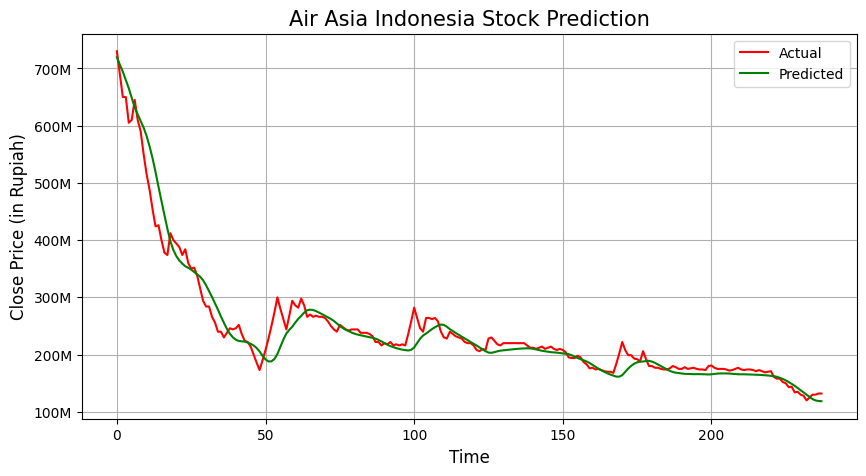

In [46]:
# Generate predictions
train_predict = model.predict(X_train)
test_predict = model.predict(X_test)
# Invert scaling for predictions
train_predict = scaler.inverse_transform(train_predict)
train_actual = scaler.inverse_transform(y_train)
test_predict = scaler.inverse_transform(test_predict)
test_actual = scaler.inverse_transform(y_test)

# Define the formatter function
def millions(x, pos):
    return '{:,.0f}M'.format(x/1e6)
# plot testing actual vs predicted values
plt.figure(figsize=(10,5))
plt.plot(test_actual, label='Actual', color='red')
plt.plot(test_predict, label='Predicted', color='green')
plt.title('Air Asia Indonesia Stock Prediction', fontsize=15)
plt.xlabel('Time', fontsize=12)
plt.ylabel('Close Price (in Rupiah)', fontsize=12)
plt.legend()
plt.grid(True)
plt.gca().yaxis.set_major_formatter(ticker.FuncFormatter(millions))
plt.show()
# Save the default model
model.save('models/cmpp_relu_rmsprop.h5')

##### ReLU - AdaDelta

In [47]:
model = Sequential()
model.add(LSTM(128, input_shape=(sequence_length, num_features), return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(64))
model.add(Dropout(0.2))
model.add(Dense(32, activation='relu'))
model.add(Dense(1))

# compile the model
model.compile(loss='mean_squared_error', optimizer='adadelta')
# train the model
model.fit(X_train, y_train, epochs=10, batch_size=100, verbose=1, validation_split=0.1)
model.summary()

Epoch 1/10
24/24 [==============================] - 27s 786ms/step - loss: 0.0241 - val_loss: 0.0120
Epoch 2/10
24/24 [==============================] - 17s 706ms/step - loss: 0.0239 - val_loss: 0.0117
Epoch 3/10
24/24 [==============================] - 18s 752ms/step - loss: 0.0237 - val_loss: 0.0115
Epoch 4/10
24/24 [==============================] - 17s 707ms/step - loss: 0.0234 - val_loss: 0.0113
Epoch 5/10
24/24 [==============================] - 17s 733ms/step - loss: 0.0230 - val_loss: 0.0111
Epoch 6/10
24/24 [==============================] - 18s 755ms/step - loss: 0.0228 - val_loss: 0.0109
Epoch 7/10
24/24 [==============================] - 18s 721ms/step - loss: 0.0227 - val_loss: 0.0107
Epoch 8/10
24/24 [==============================] - 17s 719ms/step - loss: 0.0224 - val_loss: 0.0104
Epoch 9/10
24/24 [==============================] - 19s 783ms/step - loss: 0.0222 - val_loss: 0.0102
Epoch 10/10
24/24 [==============================] - 19s 795ms/step - loss: 0.0218 - val_lo

In [48]:
# Check evaluation metrics
y_pred = model.predict(X_test)
mape = round(metrics.mean_absolute_percentage_error(y_test, y_pred), 5)
mae = round(metrics.mean_absolute_error(y_test, y_pred), 7)
mse = round(metrics.mean_squared_error(y_test, y_pred), 7)
rmse = round(math.sqrt(mse), 5)
r2 = round(metrics.r2_score(y_test, y_pred), 6)
print('Mean Absolute Percentage Error (MAPE): ', mape)
print('Mean Absolute Error (MAE): ', mae)
print('Mean Squared Error (MSE): ', mse)
print('Root Mean Squared Error (RMSE): ', rmse)
print('R-Squared: ', r2)

8/8 [==============================] - 2s 57ms/step
Mean Absolute Percentage Error (MAPE):  0.96693
Mean Absolute Error (MAE):  0.1351043
Mean Squared Error (MSE):  0.0247479
Root Mean Squared Error (RMSE):  0.15731
R-Squared:  -3.196221


8/8 [==============================] - 1s 67ms/step


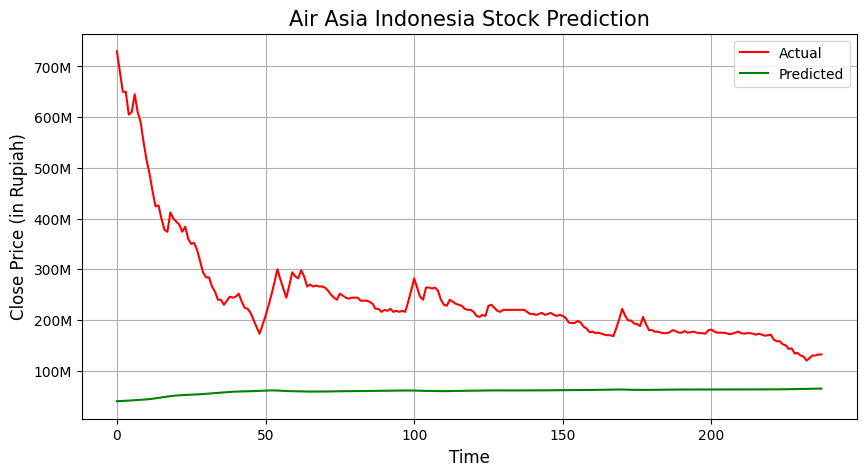

In [49]:
# Generate predictions
train_predict = model.predict(X_train)
test_predict = model.predict(X_test)
# Invert scaling for predictions
train_predict = scaler.inverse_transform(train_predict)
train_actual = scaler.inverse_transform(y_train)
test_predict = scaler.inverse_transform(test_predict)
test_actual = scaler.inverse_transform(y_test)

# Define the formatter function
def millions(x, pos):
    return '{:,.0f}M'.format(x/1e6)
# plot testing actual vs predicted values
plt.figure(figsize=(10,5))
plt.plot(test_actual, label='Actual', color='red')
plt.plot(test_predict, label='Predicted', color='green')
plt.title('Air Asia Indonesia Stock Prediction', fontsize=15)
plt.xlabel('Time', fontsize=12)
plt.ylabel('Close Price (in Rupiah)', fontsize=12)
plt.legend()
plt.grid(True)
plt.gca().yaxis.set_major_formatter(ticker.FuncFormatter(millions))
plt.show()
# Save the default model
model.save('models/cmpp_relu_adadelta.h5')

##### ReLU - SGD

In [50]:
model = Sequential()
model.add(LSTM(128, input_shape=(sequence_length, num_features), return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(64))
model.add(Dropout(0.2))
model.add(Dense(32, activation='relu'))
model.add(Dense(1))

# compile the model
model.compile(loss='mean_squared_error', optimizer='sgd')
# train the model
model.fit(X_train, y_train, epochs=10, batch_size=100, verbose=1, validation_split=0.1)
model.summary()

Epoch 1/10
24/24 [==============================] - 27s 828ms/step - loss: 0.0163 - val_loss: 0.0014
Epoch 2/10
24/24 [==============================] - 16s 680ms/step - loss: 0.0115 - val_loss: 0.0010
Epoch 3/10
24/24 [==============================] - 18s 771ms/step - loss: 0.0104 - val_loss: 0.0010
Epoch 4/10
24/24 [==============================] - 17s 715ms/step - loss: 0.0100 - val_loss: 0.0010
Epoch 5/10
24/24 [==============================] - 18s 736ms/step - loss: 0.0097 - val_loss: 0.0010
Epoch 6/10
24/24 [==============================] - 17s 719ms/step - loss: 0.0094 - val_loss: 0.0010
Epoch 7/10
24/24 [==============================] - 18s 721ms/step - loss: 0.0094 - val_loss: 0.0010
Epoch 8/10
24/24 [==============================] - 17s 710ms/step - loss: 0.0091 - val_loss: 0.0010
Epoch 9/10
24/24 [==============================] - 18s 737ms/step - loss: 0.0088 - val_loss: 0.0010
Epoch 10/10
24/24 [==============================] - 18s 758ms/step - loss: 0.0088 - val_lo

In [51]:
# Check evaluation metrics
y_pred = model.predict(X_test)
mape = round(metrics.mean_absolute_percentage_error(y_test, y_pred), 5)
mae = round(metrics.mean_absolute_error(y_test, y_pred), 7)
mse = round(metrics.mean_squared_error(y_test, y_pred), 7)
rmse = round(math.sqrt(mse), 5)
r2 = round(metrics.r2_score(y_test, y_pred), 6)
print('Mean Absolute Percentage Error (MAPE): ', mape)
print('Mean Absolute Error (MAE): ', mae)
print('Mean Squared Error (MSE): ', mse)
print('Root Mean Squared Error (RMSE): ', rmse)
print('R-Squared: ', r2)

8/8 [==============================] - 2s 56ms/step
Mean Absolute Percentage Error (MAPE):  0.23058
Mean Absolute Error (MAE):  0.0385859
Mean Squared Error (MSE):  0.0045695
Root Mean Squared Error (RMSE):  0.0676
R-Squared:  0.225195


8/8 [==============================] - 1s 66ms/step


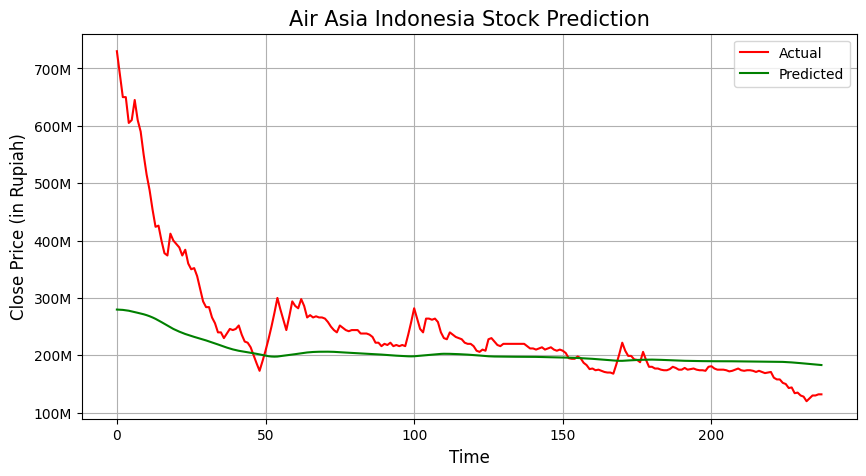

In [52]:
# Generate predictions
train_predict = model.predict(X_train)
test_predict = model.predict(X_test)
# Invert scaling for predictions
train_predict = scaler.inverse_transform(train_predict)
train_actual = scaler.inverse_transform(y_train)
test_predict = scaler.inverse_transform(test_predict)
test_actual = scaler.inverse_transform(y_test)

# Define the formatter function
def millions(x, pos):
    return '{:,.0f}M'.format(x/1e6)
# plot testing actual vs predicted values
plt.figure(figsize=(10,5))
plt.plot(test_actual, label='Actual', color='red')
plt.plot(test_predict, label='Predicted', color='green')
plt.title('Air Asia Indonesia Stock Prediction', fontsize=15)
plt.xlabel('Time', fontsize=12)
plt.ylabel('Close Price (in Rupiah)', fontsize=12)
plt.legend()
plt.grid(True)
plt.gca().yaxis.set_major_formatter(ticker.FuncFormatter(millions))
plt.show()
# Save the default model
model.save('models/cmpp_relu_sgd.h5')

##### ReLU - Adamax

In [53]:
model = Sequential()
model.add(LSTM(128, input_shape=(sequence_length, num_features), return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(64))
model.add(Dropout(0.2))
model.add(Dense(32, activation='relu'))
model.add(Dense(1))

# compile the model
model.compile(loss='mean_squared_error', optimizer='adamax')
# train the model
model.fit(X_train, y_train, epochs=10, batch_size=100, verbose=1, validation_split=0.1)
model.summary()

Epoch 1/10
24/24 [==============================] - 25s 684ms/step - loss: 0.0071 - val_loss: 9.0346e-04
Epoch 2/10
24/24 [==============================] - 14s 573ms/step - loss: 0.0030 - val_loss: 9.0223e-04
Epoch 3/10
24/24 [==============================] - 14s 580ms/step - loss: 0.0023 - val_loss: 8.2519e-04
Epoch 4/10
24/24 [==============================] - 14s 573ms/step - loss: 0.0021 - val_loss: 9.9017e-04
Epoch 5/10
24/24 [==============================] - 13s 555ms/step - loss: 0.0019 - val_loss: 8.3864e-04
Epoch 6/10
24/24 [==============================] - 14s 569ms/step - loss: 0.0018 - val_loss: 7.3847e-04
Epoch 7/10
24/24 [==============================] - 13s 550ms/step - loss: 0.0017 - val_loss: 7.3501e-04
Epoch 8/10
24/24 [==============================] - 14s 584ms/step - loss: 0.0017 - val_loss: 7.5612e-04
Epoch 9/10
24/24 [==============================] - 14s 563ms/step - loss: 0.0016 - val_loss: 6.7374e-04
Epoch 10/10
24/24 [==============================] - 13

In [54]:
# Check evaluation metrics
y_pred = model.predict(X_test)
mape = round(metrics.mean_absolute_percentage_error(y_test, y_pred), 5)
mae = round(metrics.mean_absolute_error(y_test, y_pred), 7)
mse = round(metrics.mean_squared_error(y_test, y_pred), 7)
rmse = round(math.sqrt(mse), 5)
r2 = round(metrics.r2_score(y_test, y_pred), 6)
print('Mean Absolute Percentage Error (MAPE): ', mape)
print('Mean Absolute Error (MAE): ', mae)
print('Mean Squared Error (MSE): ', mse)
print('Root Mean Squared Error (RMSE): ', rmse)
print('R-Squared: ', r2)

8/8 [==============================] - 2s 45ms/step
Mean Absolute Percentage Error (MAPE):  0.08508
Mean Absolute Error (MAE):  0.0116105
Mean Squared Error (MSE):  0.0002839
Root Mean Squared Error (RMSE):  0.01685
R-Squared:  0.951856


8/8 [==============================] - 1s 60ms/step


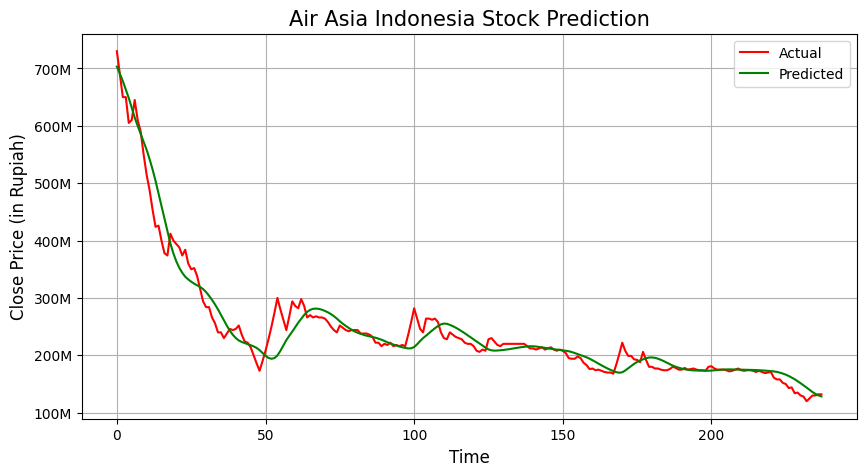

In [55]:
# Generate predictions
train_predict = model.predict(X_train)
test_predict = model.predict(X_test)
# Invert scaling for predictions
train_predict = scaler.inverse_transform(train_predict)
train_actual = scaler.inverse_transform(y_train)
test_predict = scaler.inverse_transform(test_predict)
test_actual = scaler.inverse_transform(y_test)

# Define the formatter function
def millions(x, pos):
    return '{:,.0f}M'.format(x/1e6)
# plot testing actual vs predicted values
plt.figure(figsize=(10,5))
plt.plot(test_actual, label='Actual', color='red')
plt.plot(test_predict, label='Predicted', color='green')
plt.title('Air Asia Indonesia Stock Prediction', fontsize=15)
plt.xlabel('Time', fontsize=12)
plt.ylabel('Close Price (in Rupiah)', fontsize=12)
plt.legend()
plt.grid(True)
plt.gca().yaxis.set_major_formatter(ticker.FuncFormatter(millions))
plt.show()
# Save the default model
model.save('models/cmpp_relu_adamax.h5')

##### Sigmoid - Adam

In [56]:
model = Sequential()
model.add(LSTM(128, input_shape=(sequence_length, num_features), return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(64))
model.add(Dropout(0.2))
model.add(Dense(32, activation='sigmoid'))
model.add(Dense(1))

# compile the model
model.compile(loss='mean_squared_error', optimizer='adam')
# train the model
model.fit(X_train, y_train, epochs=10, batch_size=100, verbose=1, validation_split=0.1)
model.summary()

Epoch 1/10
24/24 [==============================] - 21s 553ms/step - loss: 0.4075 - val_loss: 0.0166
Epoch 2/10
24/24 [==============================] - 10s 426ms/step - loss: 0.0202 - val_loss: 0.0020
Epoch 3/10
24/24 [==============================] - 10s 403ms/step - loss: 0.0166 - val_loss: 0.0011
Epoch 4/10
24/24 [==============================] - 10s 403ms/step - loss: 0.0151 - val_loss: 0.0011
Epoch 5/10
24/24 [==============================] - 10s 401ms/step - loss: 0.0148 - val_loss: 0.0011
Epoch 6/10
24/24 [==============================] - 10s 423ms/step - loss: 0.0140 - val_loss: 0.0010
Epoch 7/10
24/24 [==============================] - 10s 409ms/step - loss: 0.0135 - val_loss: 0.0012
Epoch 8/10
24/24 [==============================] - 10s 417ms/step - loss: 0.0131 - val_loss: 0.0015
Epoch 9/10
24/24 [==============================] - 12s 483ms/step - loss: 0.0119 - val_loss: 0.0014
Epoch 10/10
24/24 [==============================] - 10s 408ms/step - loss: 0.0107 - val_lo

In [57]:
# Check evaluation metrics
y_pred = model.predict(X_test)
mape = round(metrics.mean_absolute_percentage_error(y_test, y_pred), 5)
mae = round(metrics.mean_absolute_error(y_test, y_pred), 7)
mse = round(metrics.mean_squared_error(y_test, y_pred), 7)
rmse = round(math.sqrt(mse), 5)
r2 = round(metrics.r2_score(y_test, y_pred), 6)
print('Mean Absolute Percentage Error (MAPE): ', mape)
print('Mean Absolute Error (MAE): ', mae)
print('Mean Squared Error (MSE): ', mse)
print('Root Mean Squared Error (RMSE): ', rmse)
print('R-Squared: ', r2)

8/8 [==============================] - 5s 62ms/step
Mean Absolute Percentage Error (MAPE):  0.30039
Mean Absolute Error (MAE):  0.0504769
Mean Squared Error (MSE):  0.0059223
Root Mean Squared Error (RMSE):  0.07696
R-Squared:  -0.004179


8/8 [==============================] - 1s 75ms/step


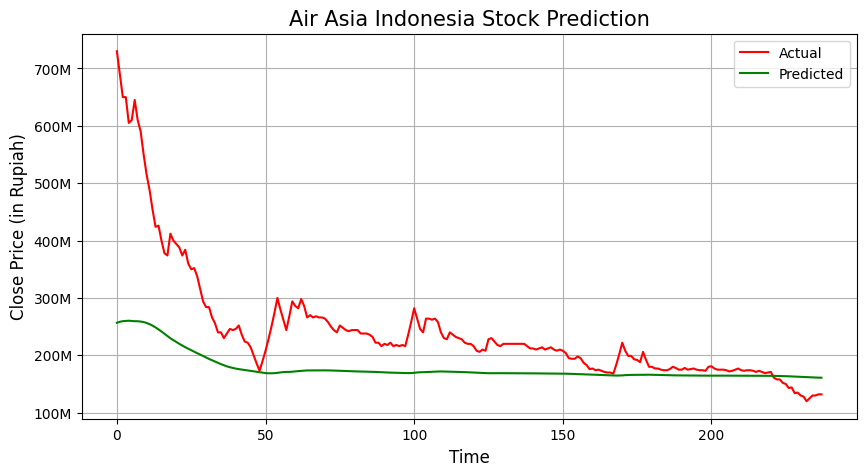

In [58]:
# Generate predictions
train_predict = model.predict(X_train)
test_predict = model.predict(X_test)
# Invert scaling for predictions
train_predict = scaler.inverse_transform(train_predict)
train_actual = scaler.inverse_transform(y_train)
test_predict = scaler.inverse_transform(test_predict)
test_actual = scaler.inverse_transform(y_test)

# Define the formatter function
def millions(x, pos):
    return '{:,.0f}M'.format(x/1e6)
# plot testing actual vs predicted values
plt.figure(figsize=(10,5))
plt.plot(test_actual, label='Actual', color='red')
plt.plot(test_predict, label='Predicted', color='green')
plt.title('Air Asia Indonesia Stock Prediction', fontsize=15)
plt.xlabel('Time', fontsize=12)
plt.ylabel('Close Price (in Rupiah)', fontsize=12)
plt.legend()
plt.grid(True)
plt.gca().yaxis.set_major_formatter(ticker.FuncFormatter(millions))
plt.show()
# Save the default model
model.save('models/cmpp_sigmoid_adam.h5')

##### Sigmoid - AdaGrad

In [59]:
model = Sequential()
model.add(LSTM(128, input_shape=(sequence_length, num_features), return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(64))
model.add(Dropout(0.2))
model.add(Dense(32, activation='sigmoid'))
model.add(Dense(1))

# compile the model
model.compile(loss='mean_squared_error', optimizer='adagrad')
# train the model
model.fit(X_train, y_train, epochs=10, batch_size=100, verbose=1, validation_split=0.1)
model.summary()

Epoch 1/10
24/24 [==============================] - 22s 403ms/step - loss: 0.2192 - val_loss: 0.1577
Epoch 2/10
24/24 [==============================] - 11s 444ms/step - loss: 0.1377 - val_loss: 0.1064
Epoch 3/10
24/24 [==============================] - 10s 408ms/step - loss: 0.0981 - val_loss: 0.0757
Epoch 4/10
24/24 [==============================] - 10s 434ms/step - loss: 0.0733 - val_loss: 0.0554
Epoch 5/10
24/24 [==============================] - 6s 260ms/step - loss: 0.0564 - val_loss: 0.0412
Epoch 6/10
24/24 [==============================] - 6s 240ms/step - loss: 0.0446 - val_loss: 0.0310
Epoch 7/10
24/24 [==============================] - 6s 240ms/step - loss: 0.0360 - val_loss: 0.0236
Epoch 8/10
24/24 [==============================] - 7s 286ms/step - loss: 0.0297 - val_loss: 0.0180
Epoch 9/10
24/24 [==============================] - 6s 256ms/step - loss: 0.0251 - val_loss: 0.0139
Epoch 10/10
24/24 [==============================] - 7s 303ms/step - loss: 0.0216 - val_loss: 0.

In [60]:
# Check evaluation metrics
y_pred = model.predict(X_test)
mape = round(metrics.mean_absolute_percentage_error(y_test, y_pred), 5)
mae = round(metrics.mean_absolute_error(y_test, y_pred), 7)
mse = round(metrics.mean_squared_error(y_test, y_pred), 7)
rmse = round(math.sqrt(mse), 5)
r2 = round(metrics.r2_score(y_test, y_pred), 6)
print('Mean Absolute Percentage Error (MAPE): ', mape)
print('Mean Absolute Error (MAE): ', mae)
print('Mean Squared Error (MSE): ', mse)
print('Root Mean Squared Error (RMSE): ', rmse)
print('R-Squared: ', r2)

8/8 [==============================] - 3s 64ms/step
Mean Absolute Percentage Error (MAPE):  0.81227
Mean Absolute Error (MAE):  0.088293
Mean Squared Error (MSE):  0.0096454
Root Mean Squared Error (RMSE):  0.09821
R-Squared:  -0.635469


8/8 [==============================] - 0s 50ms/step


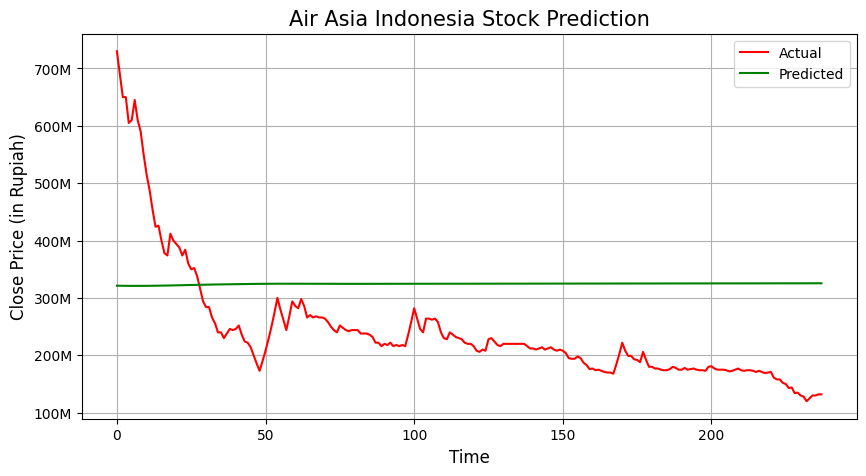

In [61]:
# Generate predictions
train_predict = model.predict(X_train)
test_predict = model.predict(X_test)
# Invert scaling for predictions
train_predict = scaler.inverse_transform(train_predict)
train_actual = scaler.inverse_transform(y_train)
test_predict = scaler.inverse_transform(test_predict)
test_actual = scaler.inverse_transform(y_test)

# Define the formatter function
def millions(x, pos):
    return '{:,.0f}M'.format(x/1e6)
# plot testing actual vs predicted values
plt.figure(figsize=(10,5))
plt.plot(test_actual, label='Actual', color='red')
plt.plot(test_predict, label='Predicted', color='green')
plt.title('Air Asia Indonesia Stock Prediction', fontsize=15)
plt.xlabel('Time', fontsize=12)
plt.ylabel('Close Price (in Rupiah)', fontsize=12)
plt.legend()
plt.grid(True)
plt.gca().yaxis.set_major_formatter(ticker.FuncFormatter(millions))
plt.show()
# Save the default model
model.save('models/cmpp_sigmoid_adagrad.h5')

##### Sigmoid - Nadam

In [62]:
model = Sequential()
model.add(LSTM(128, input_shape=(sequence_length, num_features), return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(64))
model.add(Dropout(0.2))
model.add(Dense(32, activation='sigmoid'))
model.add(Dense(1))

# compile the model
model.compile(loss='mean_squared_error', optimizer='nadam')
# train the model
model.fit(X_train, y_train, epochs=10, batch_size=100, verbose=1, validation_split=0.1)
model.summary()

Epoch 1/10
24/24 [==============================] - 30s 861ms/step - loss: 0.1752 - val_loss: 0.0010
Epoch 2/10
24/24 [==============================] - 17s 721ms/step - loss: 0.0072 - val_loss: 9.3272e-04
Epoch 3/10
24/24 [==============================] - 30s 1s/step - loss: 0.0055 - val_loss: 0.0014
Epoch 4/10
24/24 [==============================] - 24s 985ms/step - loss: 0.0047 - val_loss: 9.8290e-04
Epoch 5/10
24/24 [==============================] - 19s 783ms/step - loss: 0.0041 - val_loss: 0.0012
Epoch 6/10
24/24 [==============================] - 18s 741ms/step - loss: 0.0038 - val_loss: 0.0012
Epoch 7/10
24/24 [==============================] - 17s 702ms/step - loss: 0.0031 - val_loss: 8.9746e-04
Epoch 8/10
24/24 [==============================] - 16s 656ms/step - loss: 0.0030 - val_loss: 7.9230e-04
Epoch 9/10
24/24 [==============================] - 18s 740ms/step - loss: 0.0030 - val_loss: 8.5699e-04
Epoch 10/10
24/24 [==============================] - 19s 800ms/step - loss

In [63]:
# Check evaluation metrics
y_pred = model.predict(X_test)
mape = round(metrics.mean_absolute_percentage_error(y_test, y_pred), 5)
mae = round(metrics.mean_absolute_error(y_test, y_pred), 7)
mse = round(metrics.mean_squared_error(y_test, y_pred), 7)
rmse = round(math.sqrt(mse), 5)
r2 = round(metrics.r2_score(y_test, y_pred), 6)
print('Mean Absolute Percentage Error (MAPE): ', mape)
print('Mean Absolute Error (MAE): ', mae)
print('Mean Squared Error (MSE): ', mse)
print('Root Mean Squared Error (RMSE): ', rmse)
print('R-Squared: ', r2)

8/8 [==============================] - 2s 48ms/step
Mean Absolute Percentage Error (MAPE):  0.15587
Mean Absolute Error (MAE):  0.0190257
Mean Squared Error (MSE):  0.0005041
Root Mean Squared Error (RMSE):  0.02245
R-Squared:  0.914525


8/8 [==============================] - 0s 48ms/step


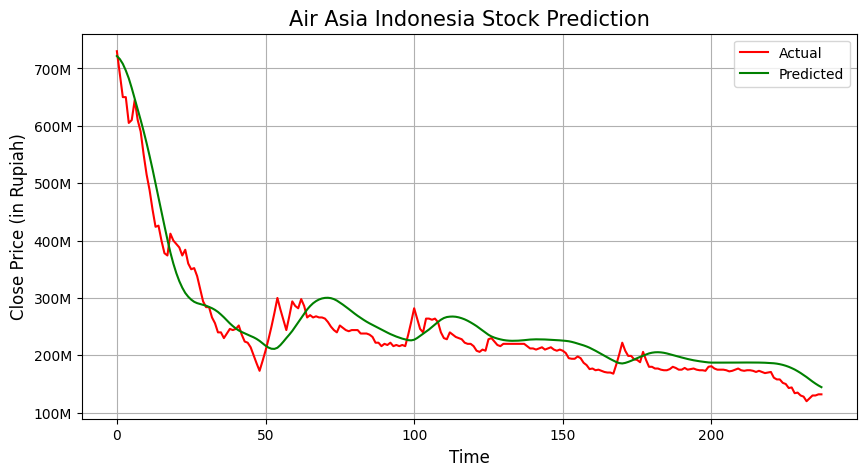

In [64]:
# Generate predictions
train_predict = model.predict(X_train)
test_predict = model.predict(X_test)
# Invert scaling for predictions
train_predict = scaler.inverse_transform(train_predict)
train_actual = scaler.inverse_transform(y_train)
test_predict = scaler.inverse_transform(test_predict)
test_actual = scaler.inverse_transform(y_test)

# Define the formatter function
def millions(x, pos):
    return '{:,.0f}M'.format(x/1e6)
# plot testing actual vs predicted values
plt.figure(figsize=(10,5))
plt.plot(test_actual, label='Actual', color='red')
plt.plot(test_predict, label='Predicted', color='green')
plt.title('Air Asia Indonesia Stock Prediction', fontsize=15)
plt.xlabel('Time', fontsize=12)
plt.ylabel('Close Price (in Rupiah)', fontsize=12)
plt.legend()
plt.grid(True)
plt.gca().yaxis.set_major_formatter(ticker.FuncFormatter(millions))
plt.show()
# Save the default model
model.save('models/cmpp_sigmoid_nadam.h5')

##### Sigmoid - RMSProp

In [65]:
model = Sequential()
model.add(LSTM(128, input_shape=(sequence_length, num_features), return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(64))
model.add(Dropout(0.2))
model.add(Dense(32, activation='sigmoid'))
model.add(Dense(1))

# compile the model
model.compile(loss='mean_squared_error', optimizer='rmsprop')
# train the model
model.fit(X_train, y_train, epochs=10, batch_size=100, verbose=1, validation_split=0.1)
model.summary()

Epoch 1/10
24/24 [==============================] - 24s 714ms/step - loss: 0.0258 - val_loss: 0.0011
Epoch 2/10
24/24 [==============================] - 16s 687ms/step - loss: 0.0050 - val_loss: 0.0012
Epoch 3/10
24/24 [==============================] - 17s 720ms/step - loss: 0.0038 - val_loss: 0.0043
Epoch 4/10
24/24 [==============================] - 17s 704ms/step - loss: 0.0034 - val_loss: 0.0014
Epoch 5/10
24/24 [==============================] - 17s 720ms/step - loss: 0.0027 - val_loss: 0.0016
Epoch 6/10
24/24 [==============================] - 16s 686ms/step - loss: 0.0028 - val_loss: 7.4682e-04
Epoch 7/10
24/24 [==============================] - 17s 718ms/step - loss: 0.0023 - val_loss: 7.5682e-04
Epoch 8/10
24/24 [==============================] - 17s 696ms/step - loss: 0.0022 - val_loss: 0.0010
Epoch 9/10
24/24 [==============================] - 18s 757ms/step - loss: 0.0021 - val_loss: 9.1807e-04
Epoch 10/10
24/24 [==============================] - 18s 734ms/step - loss: 0.0

In [66]:
# Check evaluation metrics
y_pred = model.predict(X_test)
mape = round(metrics.mean_absolute_percentage_error(y_test, y_pred), 5)
mae = round(metrics.mean_absolute_error(y_test, y_pred), 7)
mse = round(metrics.mean_squared_error(y_test, y_pred), 7)
rmse = round(math.sqrt(mse), 5)
r2 = round(metrics.r2_score(y_test, y_pred), 6)
print('Mean Absolute Percentage Error (MAPE): ', mape)
print('Mean Absolute Error (MAE): ', mae)
print('Mean Squared Error (MSE): ', mse)
print('Root Mean Squared Error (RMSE): ', rmse)
print('R-Squared: ', r2)

8/8 [==============================] - 2s 53ms/step
Mean Absolute Percentage Error (MAPE):  0.21335
Mean Absolute Error (MAE):  0.0254105
Mean Squared Error (MSE):  0.0008855
Root Mean Squared Error (RMSE):  0.02976
R-Squared:  0.849853


8/8 [==============================] - 1s 72ms/step


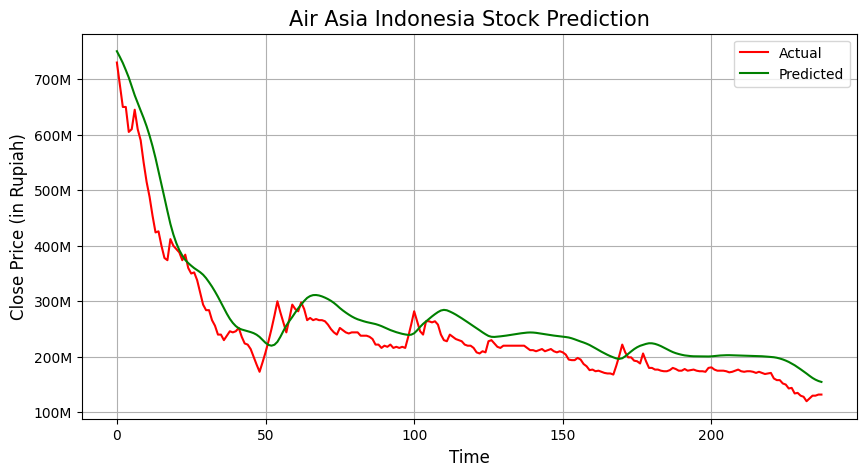

In [67]:
# Generate predictions
train_predict = model.predict(X_train)
test_predict = model.predict(X_test)
# Invert scaling for predictions
train_predict = scaler.inverse_transform(train_predict)
train_actual = scaler.inverse_transform(y_train)
test_predict = scaler.inverse_transform(test_predict)
test_actual = scaler.inverse_transform(y_test)

# Define the formatter function
def millions(x, pos):
    return '{:,.0f}M'.format(x/1e6)
# plot testing actual vs predicted values
plt.figure(figsize=(10,5))
plt.plot(test_actual, label='Actual', color='red')
plt.plot(test_predict, label='Predicted', color='green')
plt.title('Air Asia Indonesia Stock Prediction', fontsize=15)
plt.xlabel('Time', fontsize=12)
plt.ylabel('Close Price (in Rupiah)', fontsize=12)
plt.legend()
plt.grid(True)
plt.gca().yaxis.set_major_formatter(ticker.FuncFormatter(millions))
plt.show()
# Save the default model
model.save('models/cmpp_sigmoid_rmsprop.h5')

##### Sigmoid - AdaDelta

In [68]:
model = Sequential()
model.add(LSTM(128, input_shape=(sequence_length, num_features), return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(64))
model.add(Dropout(0.2))
model.add(Dense(32, activation='sigmoid'))
model.add(Dense(1))

# compile the model
model.compile(loss='mean_squared_error', optimizer='adadelta')
# train the model
model.fit(X_train, y_train, epochs=10, batch_size=100, verbose=1, validation_split=0.1)
model.summary()

Epoch 1/10
24/24 [==============================] - 34s 1s/step - loss: 0.1986 - val_loss: 0.1859
Epoch 2/10
24/24 [==============================] - 19s 800ms/step - loss: 0.1977 - val_loss: 0.1850
Epoch 3/10
24/24 [==============================] - 19s 794ms/step - loss: 0.1969 - val_loss: 0.1841
Epoch 4/10
24/24 [==============================] - 19s 808ms/step - loss: 0.1959 - val_loss: 0.1832
Epoch 5/10
24/24 [==============================] - 19s 795ms/step - loss: 0.1948 - val_loss: 0.1822
Epoch 6/10
24/24 [==============================] - 26s 1s/step - loss: 0.1940 - val_loss: 0.1813
Epoch 7/10
24/24 [==============================] - 32s 1s/step - loss: 0.1931 - val_loss: 0.1803
Epoch 8/10
24/24 [==============================] - 26s 1s/step - loss: 0.1919 - val_loss: 0.1794
Epoch 9/10
24/24 [==============================] - 25s 1s/step - loss: 0.1910 - val_loss: 0.1784
Epoch 10/10
24/24 [==============================] - 21s 849ms/step - loss: 0.1900 - val_loss: 0.1774
Mode

In [69]:
# Check evaluation metrics
y_pred = model.predict(X_test)
mape = round(metrics.mean_absolute_percentage_error(y_test, y_pred), 5)
mae = round(metrics.mean_absolute_error(y_test, y_pred), 7)
mse = round(metrics.mean_squared_error(y_test, y_pred), 7)
rmse = round(math.sqrt(mse), 5)
r2 = round(metrics.r2_score(y_test, y_pred), 6)
print('Mean Absolute Percentage Error (MAPE): ', mape)
print('Mean Absolute Error (MAE): ', mae)
print('Mean Squared Error (MSE): ', mse)
print('Root Mean Squared Error (RMSE): ', rmse)
print('R-Squared: ', r2)

8/8 [==============================] - 2s 57ms/step
Mean Absolute Percentage Error (MAPE):  3.78581
Mean Absolute Error (MAE):  0.4542029
Mean Squared Error (MSE):  0.2112903
Root Mean Squared Error (RMSE):  0.45966
R-Squared:  -34.826153


8/8 [==============================] - 1s 71ms/step


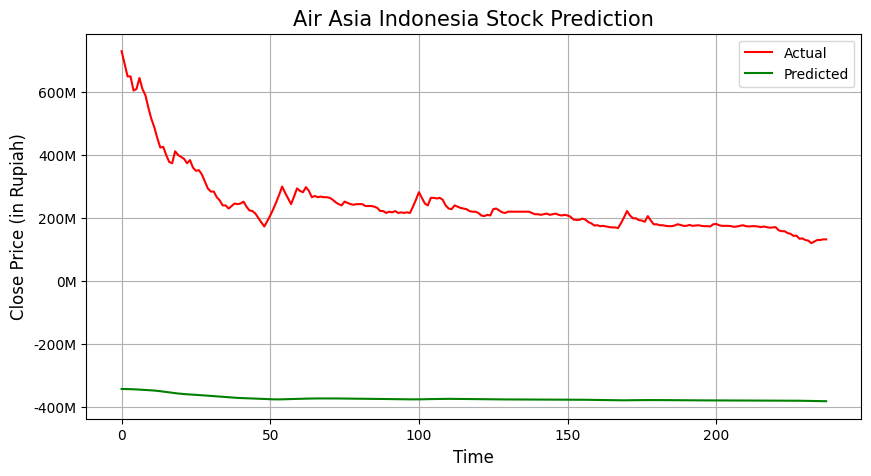

In [70]:
# Generate predictions
train_predict = model.predict(X_train)
test_predict = model.predict(X_test)
# Invert scaling for predictions
train_predict = scaler.inverse_transform(train_predict)
train_actual = scaler.inverse_transform(y_train)
test_predict = scaler.inverse_transform(test_predict)
test_actual = scaler.inverse_transform(y_test)

# Define the formatter function
def millions(x, pos):
    return '{:,.0f}M'.format(x/1e6)
# plot testing actual vs predicted values
plt.figure(figsize=(10,5))
plt.plot(test_actual, label='Actual', color='red')
plt.plot(test_predict, label='Predicted', color='green')
plt.title('Air Asia Indonesia Stock Prediction', fontsize=15)
plt.xlabel('Time', fontsize=12)
plt.ylabel('Close Price (in Rupiah)', fontsize=12)
plt.legend()
plt.grid(True)
plt.gca().yaxis.set_major_formatter(ticker.FuncFormatter(millions))
plt.show()
# Save the default model
model.save('models/cmpp_sigmoid_adadelta.h5')

##### Sigmoid - SGD

In [71]:
model = Sequential()
model.add(LSTM(128, input_shape=(sequence_length, num_features), return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(64))
model.add(Dropout(0.2))
model.add(Dense(32, activation='sigmoid'))
model.add(Dense(1))

# compile the model
model.compile(loss='mean_squared_error', optimizer='sgd')
# train the model
model.fit(X_train, y_train, epochs=10, batch_size=100, verbose=1, validation_split=0.1)
model.summary()

Epoch 1/10
24/24 [==============================] - 26s 807ms/step - loss: 0.0977 - val_loss: 0.0010
Epoch 2/10
24/24 [==============================] - 22s 912ms/step - loss: 0.0109 - val_loss: 0.0011
Epoch 3/10
24/24 [==============================] - 17s 704ms/step - loss: 0.0108 - val_loss: 0.0010
Epoch 4/10
24/24 [==============================] - 17s 690ms/step - loss: 0.0108 - val_loss: 0.0010
Epoch 5/10
24/24 [==============================] - 15s 635ms/step - loss: 0.0107 - val_loss: 0.0011
Epoch 6/10
24/24 [==============================] - 18s 771ms/step - loss: 0.0107 - val_loss: 0.0011
Epoch 7/10
24/24 [==============================] - 16s 651ms/step - loss: 0.0107 - val_loss: 0.0011
Epoch 8/10
24/24 [==============================] - 15s 629ms/step - loss: 0.0107 - val_loss: 0.0011
Epoch 9/10
24/24 [==============================] - 17s 699ms/step - loss: 0.0106 - val_loss: 0.0011
Epoch 10/10
24/24 [==============================] - 22s 937ms/step - loss: 0.0106 - val_lo

In [72]:
# Check evaluation metrics
y_pred = model.predict(X_test)
mape = round(metrics.mean_absolute_percentage_error(y_test, y_pred), 5)
mae = round(metrics.mean_absolute_error(y_test, y_pred), 7)
mse = round(metrics.mean_squared_error(y_test, y_pred), 7)
rmse = round(math.sqrt(mse), 5)
r2 = round(metrics.r2_score(y_test, y_pred), 6)
print('Mean Absolute Percentage Error (MAPE): ', mape)
print('Mean Absolute Error (MAE): ', mae)
print('Mean Squared Error (MSE): ', mse)
print('Root Mean Squared Error (RMSE): ', rmse)
print('R-Squared: ', r2)

8/8 [==============================] - 3s 63ms/step
Mean Absolute Percentage Error (MAPE):  0.27754
Mean Absolute Error (MAE):  0.0463889
Mean Squared Error (MSE):  0.0066766
Root Mean Squared Error (RMSE):  0.08171
R-Squared:  -0.132069


8/8 [==============================] - 1s 67ms/step


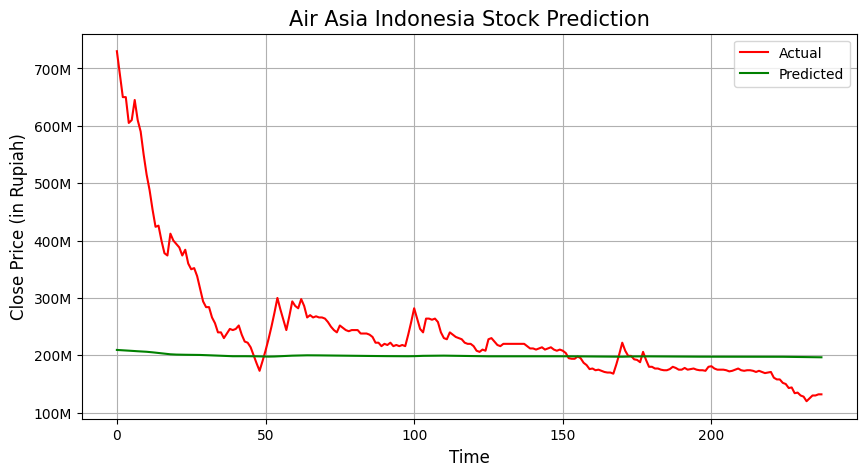

In [73]:
# Generate predictions
train_predict = model.predict(X_train)
test_predict = model.predict(X_test)
# Invert scaling for predictions
train_predict = scaler.inverse_transform(train_predict)
train_actual = scaler.inverse_transform(y_train)
test_predict = scaler.inverse_transform(test_predict)
test_actual = scaler.inverse_transform(y_test)

# Define the formatter function
def millions(x, pos):
    return '{:,.0f}M'.format(x/1e6)
# plot testing actual vs predicted values
plt.figure(figsize=(10,5))
plt.plot(test_actual, label='Actual', color='red')
plt.plot(test_predict, label='Predicted', color='green')
plt.title('Air Asia Indonesia Stock Prediction', fontsize=15)
plt.xlabel('Time', fontsize=12)
plt.ylabel('Close Price (in Rupiah)', fontsize=12)
plt.legend()
plt.grid(True)
plt.gca().yaxis.set_major_formatter(ticker.FuncFormatter(millions))
plt.show()
# Save the default model
model.save('models/cmpp_sigmoid_sgd.h5')

##### Sigmoid - Adamax

In [74]:
model = Sequential()
model.add(LSTM(128, input_shape=(sequence_length, num_features), return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(64))
model.add(Dropout(0.2))
model.add(Dense(32, activation='sigmoid'))
model.add(Dense(1))

# compile the model
model.compile(loss='mean_squared_error', optimizer='adamax')
# train the model
model.fit(X_train, y_train, epochs=10, batch_size=100, verbose=1, validation_split=0.1)
model.summary()

Epoch 1/10
24/24 [==============================] - 34s 725ms/step - loss: 0.0228 - val_loss: 0.0015
Epoch 2/10
24/24 [==============================] - 17s 716ms/step - loss: 0.0039 - val_loss: 8.9434e-04
Epoch 3/10
24/24 [==============================] - 21s 890ms/step - loss: 0.0027 - val_loss: 8.6959e-04
Epoch 4/10
24/24 [==============================] - 20s 839ms/step - loss: 0.0024 - val_loss: 8.3665e-04
Epoch 5/10
24/24 [==============================] - 18s 727ms/step - loss: 0.0021 - val_loss: 8.4364e-04
Epoch 6/10
24/24 [==============================] - 18s 738ms/step - loss: 0.0020 - val_loss: 8.7369e-04
Epoch 7/10
24/24 [==============================] - 19s 783ms/step - loss: 0.0020 - val_loss: 0.0010
Epoch 8/10
24/24 [==============================] - 17s 726ms/step - loss: 0.0019 - val_loss: 8.7094e-04
Epoch 9/10
24/24 [==============================] - 18s 732ms/step - loss: 0.0018 - val_loss: 8.1635e-04
Epoch 10/10
24/24 [==============================] - 19s 776ms/

In [75]:
# Check evaluation metrics
y_pred = model.predict(X_test)
mape = round(metrics.mean_absolute_percentage_error(y_test, y_pred), 5)
mae = round(metrics.mean_absolute_error(y_test, y_pred), 7)
mse = round(metrics.mean_squared_error(y_test, y_pred), 7)
rmse = round(math.sqrt(mse), 5)
r2 = round(metrics.r2_score(y_test, y_pred), 6)
print('Mean Absolute Percentage Error (MAPE): ', mape)
print('Mean Absolute Error (MAE): ', mae)
print('Mean Squared Error (MSE): ', mse)
print('Root Mean Squared Error (RMSE): ', rmse)
print('R-Squared: ', r2)

8/8 [==============================] - 3s 68ms/step
Mean Absolute Percentage Error (MAPE):  0.14426
Mean Absolute Error (MAE):  0.0186483
Mean Squared Error (MSE):  0.0005954
Root Mean Squared Error (RMSE):  0.0244
R-Squared:  0.899048


8/8 [==============================] - 0s 56ms/step


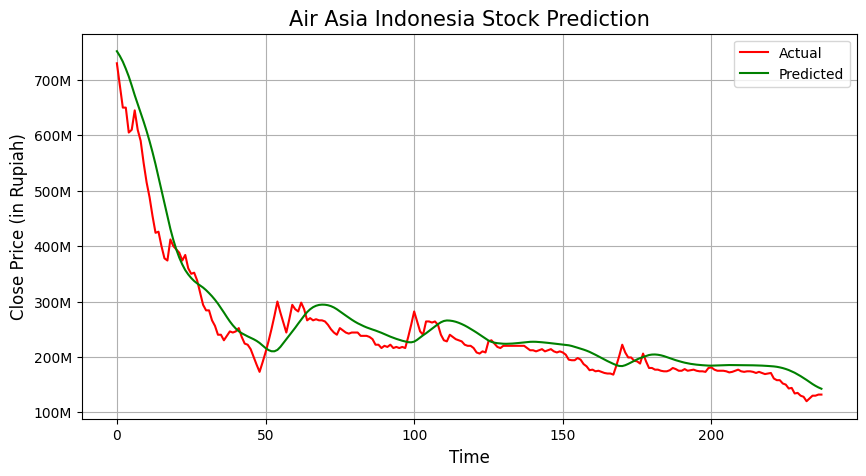

In [76]:
# Generate predictions
train_predict = model.predict(X_train)
test_predict = model.predict(X_test)
# Invert scaling for predictions
train_predict = scaler.inverse_transform(train_predict)
train_actual = scaler.inverse_transform(y_train)
test_predict = scaler.inverse_transform(test_predict)
test_actual = scaler.inverse_transform(y_test)

# Define the formatter function
def millions(x, pos):
    return '{:,.0f}M'.format(x/1e6)
# plot testing actual vs predicted values
plt.figure(figsize=(10,5))
plt.plot(test_actual, label='Actual', color='red')
plt.plot(test_predict, label='Predicted', color='green')
plt.title('Air Asia Indonesia Stock Prediction', fontsize=15)
plt.xlabel('Time', fontsize=12)
plt.ylabel('Close Price (in Rupiah)', fontsize=12)
plt.legend()
plt.grid(True)
plt.gca().yaxis.set_major_formatter(ticker.FuncFormatter(millions))
plt.show()
# Save the default model
model.save('models/cmpp_sigmoid_adamax.h5')

##### Tanh - Adam

In [77]:
model = Sequential()
model.add(LSTM(128, input_shape=(sequence_length, num_features), return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(64))
model.add(Dropout(0.2))
model.add(Dense(32, activation='tanh'))
model.add(Dense(1))

# compile the model
model.compile(loss='mean_squared_error', optimizer='adam')
# train the model
model.fit(X_train, y_train, epochs=10, batch_size=100, verbose=1, validation_split=0.1)
model.summary()

Epoch 1/10
24/24 [==============================] - 29s 827ms/step - loss: 0.0042 - val_loss: 9.4044e-04
Epoch 2/10
24/24 [==============================] - 18s 770ms/step - loss: 0.0016 - val_loss: 6.3566e-04
Epoch 3/10
24/24 [==============================] - 19s 817ms/step - loss: 0.0014 - val_loss: 6.0070e-04
Epoch 4/10
24/24 [==============================] - 16s 649ms/step - loss: 0.0014 - val_loss: 6.9776e-04
Epoch 5/10
24/24 [==============================] - 16s 651ms/step - loss: 0.0012 - val_loss: 4.6016e-04
Epoch 6/10
24/24 [==============================] - 16s 683ms/step - loss: 0.0011 - val_loss: 4.4163e-04
Epoch 7/10
24/24 [==============================] - 20s 850ms/step - loss: 0.0011 - val_loss: 3.6812e-04
Epoch 8/10
24/24 [==============================] - 17s 704ms/step - loss: 9.7864e-04 - val_loss: 3.7954e-04
Epoch 9/10
24/24 [==============================] - 19s 783ms/step - loss: 8.4917e-04 - val_loss: 2.9884e-04
Epoch 10/10
24/24 [============================

In [78]:
# Check evaluation metrics
y_pred = model.predict(X_test)
mape = round(metrics.mean_absolute_percentage_error(y_test, y_pred), 5)
mae = round(metrics.mean_absolute_error(y_test, y_pred), 7)
mse = round(metrics.mean_squared_error(y_test, y_pred), 7)
rmse = round(math.sqrt(mse), 5)
r2 = round(metrics.r2_score(y_test, y_pred), 6)
print('Mean Absolute Percentage Error (MAPE): ', mape)
print('Mean Absolute Error (MAE): ', mae)
print('Mean Squared Error (MSE): ', mse)
print('Root Mean Squared Error (RMSE): ', rmse)
print('R-Squared: ', r2)

8/8 [==============================] - 3s 77ms/step
Mean Absolute Percentage Error (MAPE):  0.06234
Mean Absolute Error (MAE):  0.0092166
Mean Squared Error (MSE):  0.0002233
Root Mean Squared Error (RMSE):  0.01494
R-Squared:  0.962144


8/8 [==============================] - 1s 76ms/step


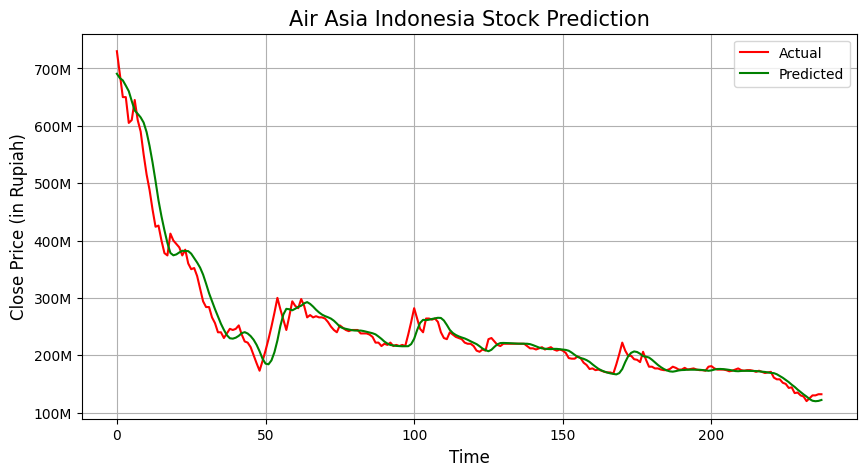

In [79]:
# Generate predictions
train_predict = model.predict(X_train)
test_predict = model.predict(X_test)
# Invert scaling for predictions
train_predict = scaler.inverse_transform(train_predict)
train_actual = scaler.inverse_transform(y_train)
test_predict = scaler.inverse_transform(test_predict)
test_actual = scaler.inverse_transform(y_test)

# Define the formatter function
def millions(x, pos):
    return '{:,.0f}M'.format(x/1e6)
# plot testing actual vs predicted values
plt.figure(figsize=(10,5))
plt.plot(test_actual, label='Actual', color='red')
plt.plot(test_predict, label='Predicted', color='green')
plt.title('Air Asia Indonesia Stock Prediction', fontsize=15)
plt.xlabel('Time', fontsize=12)
plt.ylabel('Close Price (in Rupiah)', fontsize=12)
plt.legend()
plt.grid(True)
plt.gca().yaxis.set_major_formatter(ticker.FuncFormatter(millions))
plt.show()
# Save the default model
model.save('models/cmpp_tanh_adam.h5')

##### Tanh - AdaGrad

In [80]:
model = Sequential()
model.add(LSTM(128, input_shape=(sequence_length, num_features), return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(64))
model.add(Dropout(0.2))
model.add(Dense(32, activation='tanh'))
model.add(Dense(1))

# compile the model
model.compile(loss='mean_squared_error', optimizer='adagrad')
# train the model
model.fit(X_train, y_train, epochs=10, batch_size=100, verbose=1, validation_split=0.1)
model.summary()

Epoch 1/10
24/24 [==============================] - 31s 930ms/step - loss: 0.0121 - val_loss: 0.0016
Epoch 2/10
24/24 [==============================] - 20s 833ms/step - loss: 0.0088 - val_loss: 0.0011
Epoch 3/10
24/24 [==============================] - 20s 811ms/step - loss: 0.0084 - val_loss: 0.0010
Epoch 4/10
24/24 [==============================] - 20s 835ms/step - loss: 0.0084 - val_loss: 0.0010
Epoch 5/10
24/24 [==============================] - 19s 788ms/step - loss: 0.0081 - val_loss: 0.0010
Epoch 6/10
24/24 [==============================] - 21s 881ms/step - loss: 0.0078 - val_loss: 0.0010
Epoch 7/10
24/24 [==============================] - 19s 791ms/step - loss: 0.0075 - val_loss: 0.0010
Epoch 8/10
24/24 [==============================] - 20s 830ms/step - loss: 0.0080 - val_loss: 0.0010
Epoch 9/10
24/24 [==============================] - 21s 883ms/step - loss: 0.0076 - val_loss: 0.0010
Epoch 10/10
24/24 [==============================] - 20s 830ms/step - loss: 0.0076 - val_lo

In [81]:
# Check evaluation metrics
y_pred = model.predict(X_test)
mape = round(metrics.mean_absolute_percentage_error(y_test, y_pred), 5)
mae = round(metrics.mean_absolute_error(y_test, y_pred), 7)
mse = round(metrics.mean_squared_error(y_test, y_pred), 7)
rmse = round(math.sqrt(mse), 5)
r2 = round(metrics.r2_score(y_test, y_pred), 6)
print('Mean Absolute Percentage Error (MAPE): ', mape)
print('Mean Absolute Error (MAE): ', mae)
print('Mean Squared Error (MSE): ', mse)
print('Root Mean Squared Error (RMSE): ', rmse)
print('R-Squared: ', r2)

8/8 [==============================] - 3s 63ms/step
Mean Absolute Percentage Error (MAPE):  0.208
Mean Absolute Error (MAE):  0.0334716
Mean Squared Error (MSE):  0.0034537
Root Mean Squared Error (RMSE):  0.05877
R-Squared:  0.414388


8/8 [==============================] - 1s 82ms/step


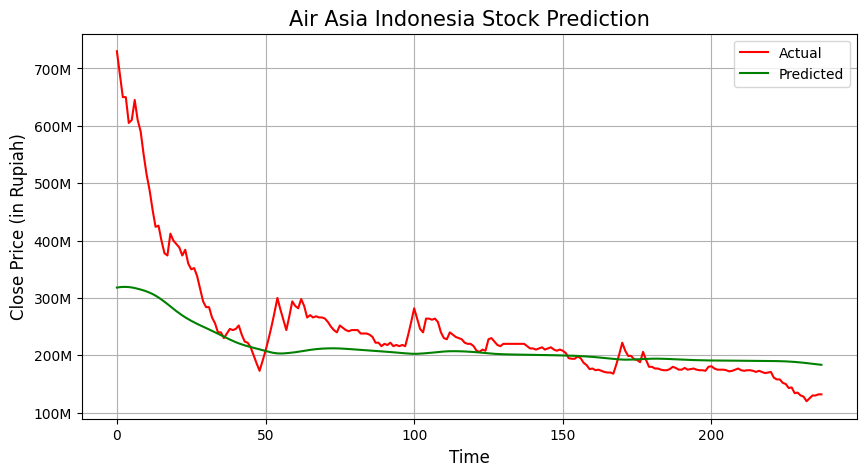

In [82]:
# Generate predictions
train_predict = model.predict(X_train)
test_predict = model.predict(X_test)
# Invert scaling for predictions
train_predict = scaler.inverse_transform(train_predict)
train_actual = scaler.inverse_transform(y_train)
test_predict = scaler.inverse_transform(test_predict)
test_actual = scaler.inverse_transform(y_test)

# Define the formatter function
def millions(x, pos):
    return '{:,.0f}M'.format(x/1e6)
# plot testing actual vs predicted values
plt.figure(figsize=(10,5))
plt.plot(test_actual, label='Actual', color='red')
plt.plot(test_predict, label='Predicted', color='green')
plt.title('Air Asia Indonesia Stock Prediction', fontsize=15)
plt.xlabel('Time', fontsize=12)
plt.ylabel('Close Price (in Rupiah)', fontsize=12)
plt.legend()
plt.grid(True)
plt.gca().yaxis.set_major_formatter(ticker.FuncFormatter(millions))
plt.show()
# Save the default model
model.save('models/cmpp_tanh_adagrad.h5')

##### Tanh - Nadam

In [83]:
model = Sequential()
model.add(LSTM(128, input_shape=(sequence_length, num_features), return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(64))
model.add(Dropout(0.2))
model.add(Dense(32, activation='tanh'))
model.add(Dense(1))

# compile the model
model.compile(loss='mean_squared_error', optimizer='nadam')
# train the model
model.fit(X_train, y_train, epochs=10, batch_size=100, verbose=1, validation_split=0.1)
model.summary()

Epoch 1/10
24/24 [==============================] - 35s 970ms/step - loss: 0.0058 - val_loss: 0.0012
Epoch 2/10
24/24 [==============================] - 18s 761ms/step - loss: 0.0018 - val_loss: 6.5897e-04
Epoch 3/10
24/24 [==============================] - 21s 897ms/step - loss: 0.0013 - val_loss: 5.6585e-04
Epoch 4/10
24/24 [==============================] - 21s 870ms/step - loss: 0.0012 - val_loss: 7.4160e-04
Epoch 5/10
24/24 [==============================] - 20s 833ms/step - loss: 0.0013 - val_loss: 4.7613e-04
Epoch 6/10
24/24 [==============================] - 20s 834ms/step - loss: 0.0011 - val_loss: 4.3445e-04
Epoch 7/10
24/24 [==============================] - 19s 818ms/step - loss: 0.0011 - val_loss: 4.2673e-04
Epoch 8/10
24/24 [==============================] - 21s 883ms/step - loss: 0.0011 - val_loss: 4.9633e-04
Epoch 9/10
24/24 [==============================] - 19s 814ms/step - loss: 9.4755e-04 - val_loss: 3.2629e-04
Epoch 10/10
24/24 [==============================] - 19

In [84]:
# Check evaluation metrics
y_pred = model.predict(X_test)
mape = round(metrics.mean_absolute_percentage_error(y_test, y_pred), 5)
mae = round(metrics.mean_absolute_error(y_test, y_pred), 7)
mse = round(metrics.mean_squared_error(y_test, y_pred), 7)
rmse = round(math.sqrt(mse), 5)
r2 = round(metrics.r2_score(y_test, y_pred), 6)
print('Mean Absolute Percentage Error (MAPE): ', mape)
print('Mean Absolute Error (MAE): ', mae)
print('Mean Squared Error (MSE): ', mse)
print('Root Mean Squared Error (RMSE): ', rmse)
print('R-Squared: ', r2)

8/8 [==============================] - 2s 75ms/step
Mean Absolute Percentage Error (MAPE):  0.11086
Mean Absolute Error (MAE):  0.0147993
Mean Squared Error (MSE):  0.0003815
Root Mean Squared Error (RMSE):  0.01953
R-Squared:  0.93531


8/8 [==============================] - 1s 76ms/step


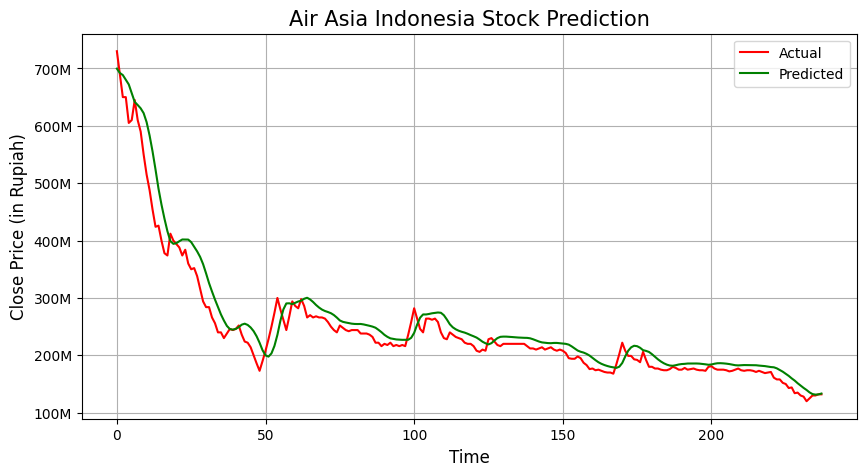

In [85]:
# Generate predictions
train_predict = model.predict(X_train)
test_predict = model.predict(X_test)
# Invert scaling for predictions
train_predict = scaler.inverse_transform(train_predict)
train_actual = scaler.inverse_transform(y_train)
test_predict = scaler.inverse_transform(test_predict)
test_actual = scaler.inverse_transform(y_test)

# Define the formatter function
def millions(x, pos):
    return '{:,.0f}M'.format(x/1e6)
# plot testing actual vs predicted values
plt.figure(figsize=(10,5))
plt.plot(test_actual, label='Actual', color='red')
plt.plot(test_predict, label='Predicted', color='green')
plt.title('Air Asia Indonesia Stock Prediction', fontsize=15)
plt.xlabel('Time', fontsize=12)
plt.ylabel('Close Price (in Rupiah)', fontsize=12)
plt.legend()
plt.grid(True)
plt.gca().yaxis.set_major_formatter(ticker.FuncFormatter(millions))
plt.show()
# Save the default model
model.save('models/cmpp_tanh_nadam.h5')

##### Tanh - RMSProp

In [86]:
model = Sequential()
model.add(LSTM(128, input_shape=(sequence_length, num_features), return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(64))
model.add(Dropout(0.2))
model.add(Dense(32, activation='tanh'))
model.add(Dense(1))

# compile the model
model.compile(loss='mean_squared_error', optimizer='rmsprop')
# train the model
model.fit(X_train, y_train, epochs=10, batch_size=100, verbose=1, validation_split=0.1)
model.summary()

Epoch 1/10
24/24 [==============================] - 28s 796ms/step - loss: 0.0048 - val_loss: 9.8175e-04
Epoch 2/10
24/24 [==============================] - 18s 743ms/step - loss: 0.0023 - val_loss: 7.8236e-04
Epoch 3/10
24/24 [==============================] - 19s 778ms/step - loss: 0.0022 - val_loss: 9.0857e-04
Epoch 4/10
24/24 [==============================] - 18s 761ms/step - loss: 0.0020 - val_loss: 6.4334e-04
Epoch 5/10
24/24 [==============================] - 17s 725ms/step - loss: 0.0017 - val_loss: 0.0012
Epoch 6/10
24/24 [==============================] - 19s 793ms/step - loss: 0.0018 - val_loss: 0.0012
Epoch 7/10
24/24 [==============================] - 20s 847ms/step - loss: 0.0014 - val_loss: 6.5912e-04
Epoch 8/10
24/24 [==============================] - 19s 789ms/step - loss: 0.0015 - val_loss: 5.8664e-04
Epoch 9/10
24/24 [==============================] - 20s 841ms/step - loss: 0.0016 - val_loss: 0.0012
Epoch 10/10
24/24 [==============================] - 22s 903ms/step

In [87]:
# Check evaluation metrics
y_pred = model.predict(X_test)
mape = round(metrics.mean_absolute_percentage_error(y_test, y_pred), 5)
mae = round(metrics.mean_absolute_error(y_test, y_pred), 7)
mse = round(metrics.mean_squared_error(y_test, y_pred), 7)
rmse = round(math.sqrt(mse), 5)
r2 = round(metrics.r2_score(y_test, y_pred), 6)
print('Mean Absolute Percentage Error (MAPE): ', mape)
print('Mean Absolute Error (MAE): ', mae)
print('Mean Squared Error (MSE): ', mse)
print('Root Mean Squared Error (RMSE): ', rmse)
print('R-Squared: ', r2)

8/8 [==============================] - 2s 67ms/step
Mean Absolute Percentage Error (MAPE):  0.23987
Mean Absolute Error (MAE):  0.0294759
Mean Squared Error (MSE):  0.0011392
Root Mean Squared Error (RMSE):  0.03375
R-Squared:  0.806844


8/8 [==============================] - 1s 65ms/step


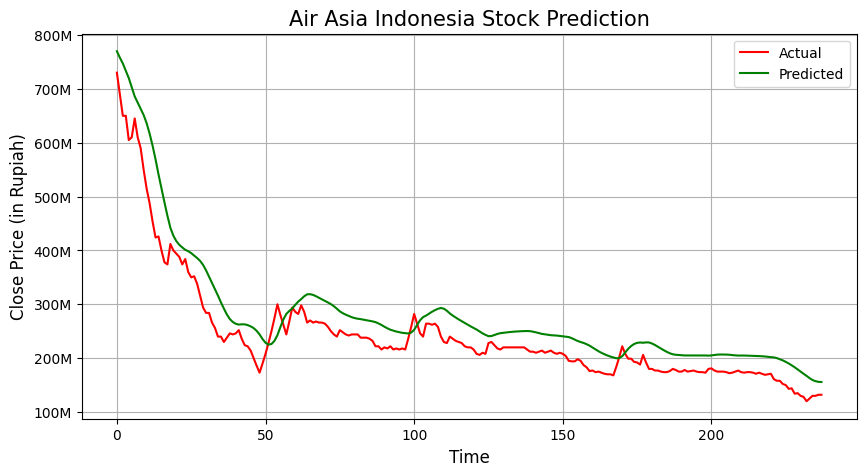

In [88]:
# Generate predictions
train_predict = model.predict(X_train)
test_predict = model.predict(X_test)
# Invert scaling for predictions
train_predict = scaler.inverse_transform(train_predict)
train_actual = scaler.inverse_transform(y_train)
test_predict = scaler.inverse_transform(test_predict)
test_actual = scaler.inverse_transform(y_test)

# Define the formatter function
def millions(x, pos):
    return '{:,.0f}M'.format(x/1e6)
# plot testing actual vs predicted values
plt.figure(figsize=(10,5))
plt.plot(test_actual, label='Actual', color='red')
plt.plot(test_predict, label='Predicted', color='green')
plt.title('Air Asia Indonesia Stock Prediction', fontsize=15)
plt.xlabel('Time', fontsize=12)
plt.ylabel('Close Price (in Rupiah)', fontsize=12)
plt.legend()
plt.grid(True)
plt.gca().yaxis.set_major_formatter(ticker.FuncFormatter(millions))
plt.show()
# Save the default model
model.save('models/cmpp_tanh_rmsprop.h5')

##### Tanh - AdaDelta

In [89]:
model = Sequential()
model.add(LSTM(128, input_shape=(sequence_length, num_features), return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(64))
model.add(Dropout(0.2))
model.add(Dense(32, activation='tanh'))
model.add(Dense(1))

# compile the model
model.compile(loss='mean_squared_error', optimizer='adadelta')
# train the model
model.fit(X_train, y_train, epochs=10, batch_size=100, verbose=1, validation_split=0.1)
model.summary()

Epoch 1/10
24/24 [==============================] - 31s 895ms/step - loss: 0.0240 - val_loss: 0.0117
Epoch 2/10
24/24 [==============================] - 20s 851ms/step - loss: 0.0236 - val_loss: 0.0114
Epoch 3/10
24/24 [==============================] - 19s 808ms/step - loss: 0.0230 - val_loss: 0.0111
Epoch 4/10
24/24 [==============================] - 20s 836ms/step - loss: 0.0226 - val_loss: 0.0108
Epoch 5/10
24/24 [==============================] - 20s 835ms/step - loss: 0.0222 - val_loss: 0.0105
Epoch 6/10
24/24 [==============================] - 21s 857ms/step - loss: 0.0221 - val_loss: 0.0102
Epoch 7/10
24/24 [==============================] - 19s 808ms/step - loss: 0.0217 - val_loss: 0.0099
Epoch 8/10
24/24 [==============================] - 20s 818ms/step - loss: 0.0212 - val_loss: 0.0097
Epoch 9/10
24/24 [==============================] - 21s 871ms/step - loss: 0.0209 - val_loss: 0.0094
Epoch 10/10
24/24 [==============================] - 17s 695ms/step - loss: 0.0204 - val_lo

In [90]:
# Check evaluation metrics
y_pred = model.predict(X_test)
mape = round(metrics.mean_absolute_percentage_error(y_test, y_pred), 5)
mae = round(metrics.mean_absolute_error(y_test, y_pred), 7)
mse = round(metrics.mean_squared_error(y_test, y_pred), 7)
rmse = round(math.sqrt(mse), 5)
r2 = round(metrics.r2_score(y_test, y_pred), 6)
print('Mean Absolute Percentage Error (MAPE): ', mape)
print('Mean Absolute Error (MAE): ', mae)
print('Mean Squared Error (MSE): ', mse)
print('Root Mean Squared Error (RMSE): ', rmse)
print('R-Squared: ', r2)

8/8 [==============================] - 2s 51ms/step
Mean Absolute Percentage Error (MAPE):  0.91432
Mean Absolute Error (MAE):  0.1283619
Mean Squared Error (MSE):  0.0225905
Root Mean Squared Error (RMSE):  0.1503
R-Squared:  -2.830418


8/8 [==============================] - 0s 52ms/step


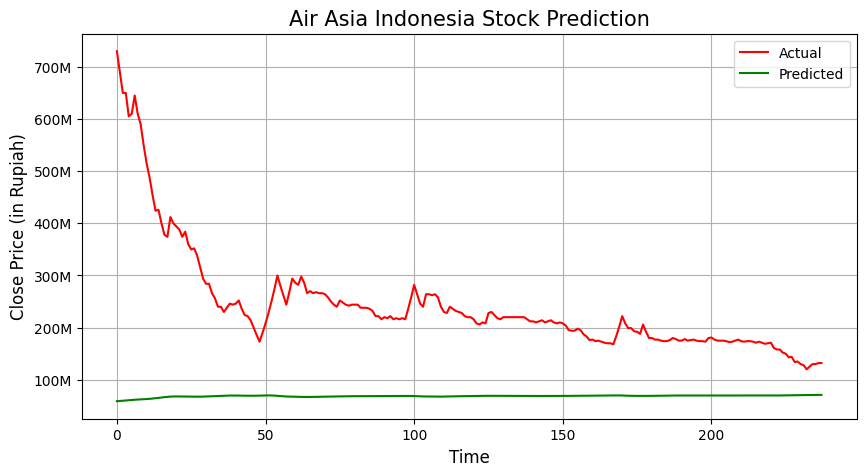

In [91]:
# Generate predictions
train_predict = model.predict(X_train)
test_predict = model.predict(X_test)
# Invert scaling for predictions
train_predict = scaler.inverse_transform(train_predict)
train_actual = scaler.inverse_transform(y_train)
test_predict = scaler.inverse_transform(test_predict)
test_actual = scaler.inverse_transform(y_test)

# Define the formatter function
def millions(x, pos):
    return '{:,.0f}M'.format(x/1e6)
# plot testing actual vs predicted values
plt.figure(figsize=(10,5))
plt.plot(test_actual, label='Actual', color='red')
plt.plot(test_predict, label='Predicted', color='green')
plt.title('Air Asia Indonesia Stock Prediction', fontsize=15)
plt.xlabel('Time', fontsize=12)
plt.ylabel('Close Price (in Rupiah)', fontsize=12)
plt.legend()
plt.grid(True)
plt.gca().yaxis.set_major_formatter(ticker.FuncFormatter(millions))
plt.show()
# Save the default model
model.save('models/cmpp_tanh_adadelta.h5')

##### Tanh - SGD

In [92]:
model = Sequential()
model.add(LSTM(128, input_shape=(sequence_length, num_features), return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(64))
model.add(Dropout(0.2))
model.add(Dense(32, activation='tanh'))
model.add(Dense(1))

# compile the model
model.compile(loss='mean_squared_error', optimizer='sgd')
# train the model
model.fit(X_train, y_train, epochs=10, batch_size=100, verbose=1, validation_split=0.1)
model.summary()

Epoch 1/10
24/24 [==============================] - 24s 714ms/step - loss: 0.0099 - val_loss: 0.0010
Epoch 2/10
24/24 [==============================] - 16s 678ms/step - loss: 0.0085 - val_loss: 0.0010
Epoch 3/10
24/24 [==============================] - 16s 664ms/step - loss: 0.0078 - val_loss: 0.0010
Epoch 4/10
24/24 [==============================] - 16s 666ms/step - loss: 0.0079 - val_loss: 0.0010
Epoch 5/10
24/24 [==============================] - 16s 658ms/step - loss: 0.0074 - val_loss: 0.0010
Epoch 6/10
24/24 [==============================] - 16s 686ms/step - loss: 0.0073 - val_loss: 9.9229e-04
Epoch 7/10
24/24 [==============================] - 16s 663ms/step - loss: 0.0072 - val_loss: 9.9011e-04
Epoch 8/10
24/24 [==============================] - 16s 671ms/step - loss: 0.0068 - val_loss: 0.0010
Epoch 9/10
24/24 [==============================] - 16s 672ms/step - loss: 0.0066 - val_loss: 9.7606e-04
Epoch 10/10
24/24 [==============================] - 17s 696ms/step - loss: 0.0

In [93]:
# Check evaluation metrics
y_pred = model.predict(X_test)
mape = round(metrics.mean_absolute_percentage_error(y_test, y_pred), 5)
mae = round(metrics.mean_absolute_error(y_test, y_pred), 7)
mse = round(metrics.mean_squared_error(y_test, y_pred), 7)
rmse = round(math.sqrt(mse), 5)
r2 = round(metrics.r2_score(y_test, y_pred), 6)
print('Mean Absolute Percentage Error (MAPE): ', mape)
print('Mean Absolute Error (MAE): ', mae)
print('Mean Squared Error (MSE): ', mse)
print('Root Mean Squared Error (RMSE): ', rmse)
print('R-Squared: ', r2)

8/8 [==============================] - 2s 56ms/step
Mean Absolute Percentage Error (MAPE):  0.18623
Mean Absolute Error (MAE):  0.0295602
Mean Squared Error (MSE):  0.0026835
Root Mean Squared Error (RMSE):  0.0518
R-Squared:  0.544981


8/8 [==============================] - 0s 53ms/step


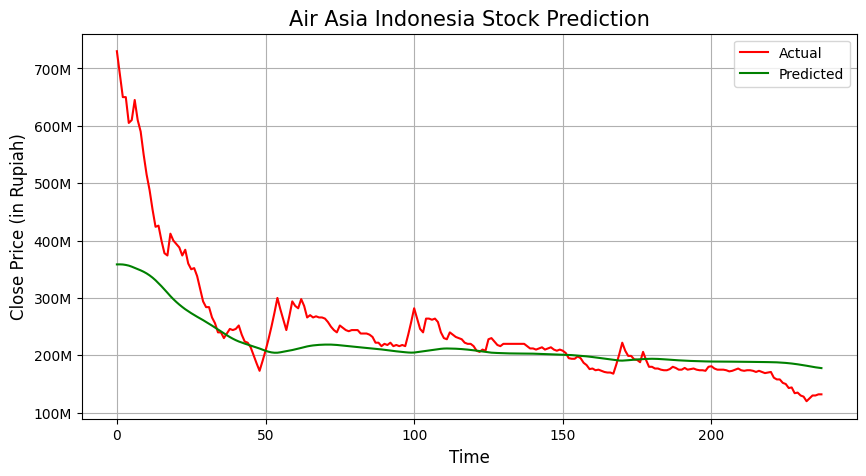

In [94]:
# Generate predictions
train_predict = model.predict(X_train)
test_predict = model.predict(X_test)
# Invert scaling for predictions
train_predict = scaler.inverse_transform(train_predict)
train_actual = scaler.inverse_transform(y_train)
test_predict = scaler.inverse_transform(test_predict)
test_actual = scaler.inverse_transform(y_test)

# Define the formatter function
def millions(x, pos):
    return '{:,.0f}M'.format(x/1e6)
# plot testing actual vs predicted values
plt.figure(figsize=(10,5))
plt.plot(test_actual, label='Actual', color='red')
plt.plot(test_predict, label='Predicted', color='green')
plt.title('Air Asia Indonesia Stock Prediction', fontsize=15)
plt.xlabel('Time', fontsize=12)
plt.ylabel('Close Price (in Rupiah)', fontsize=12)
plt.legend()
plt.grid(True)
plt.gca().yaxis.set_major_formatter(ticker.FuncFormatter(millions))
plt.show()
# Save the default model
model.save('models/cmpp_tanh_sgd.h5')

##### Tanh - Adamax

In [95]:
model = Sequential()
model.add(LSTM(128, input_shape=(sequence_length, num_features), return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(64))
model.add(Dropout(0.2))
model.add(Dense(32, activation='tanh'))
model.add(Dense(1))

# compile the model
model.compile(loss='mean_squared_error', optimizer='adamax')
# train the model
model.fit(X_train, y_train, epochs=10, batch_size=100, verbose=1, validation_split=0.1)
model.summary()

Epoch 1/10
24/24 [==============================] - 24s 712ms/step - loss: 0.0040 - val_loss: 8.2875e-04
Epoch 2/10
24/24 [==============================] - 16s 651ms/step - loss: 0.0020 - val_loss: 7.3074e-04
Epoch 3/10
24/24 [==============================] - 16s 685ms/step - loss: 0.0016 - val_loss: 6.6437e-04
Epoch 4/10
24/24 [==============================] - 16s 668ms/step - loss: 0.0016 - val_loss: 6.7463e-04
Epoch 5/10
24/24 [==============================] - 16s 667ms/step - loss: 0.0016 - val_loss: 6.1499e-04
Epoch 6/10
24/24 [==============================] - 16s 679ms/step - loss: 0.0013 - val_loss: 5.9136e-04
Epoch 7/10
24/24 [==============================] - 17s 690ms/step - loss: 0.0015 - val_loss: 5.5349e-04
Epoch 8/10
24/24 [==============================] - 16s 686ms/step - loss: 0.0012 - val_loss: 5.5919e-04
Epoch 9/10
24/24 [==============================] - 16s 649ms/step - loss: 0.0011 - val_loss: 5.6183e-04
Epoch 10/10
24/24 [==============================] - 16

In [96]:
# Check evaluation metrics
y_pred = model.predict(X_test)
mape = round(metrics.mean_absolute_percentage_error(y_test, y_pred), 5)
mae = round(metrics.mean_absolute_error(y_test, y_pred), 7)
mse = round(metrics.mean_squared_error(y_test, y_pred), 7)
rmse = round(math.sqrt(mse), 5)
r2 = round(metrics.r2_score(y_test, y_pred), 6)
print('Mean Absolute Percentage Error (MAPE): ', mape)
print('Mean Absolute Error (MAE): ', mae)
print('Mean Squared Error (MSE): ', mse)
print('Root Mean Squared Error (RMSE): ', rmse)
print('R-Squared: ', r2)

8/8 [==============================] - 2s 55ms/step
Mean Absolute Percentage Error (MAPE):  0.08206
Mean Absolute Error (MAE):  0.0115234
Mean Squared Error (MSE):  0.0003038
Root Mean Squared Error (RMSE):  0.01743
R-Squared:  0.948495


8/8 [==============================] - 1s 60ms/step


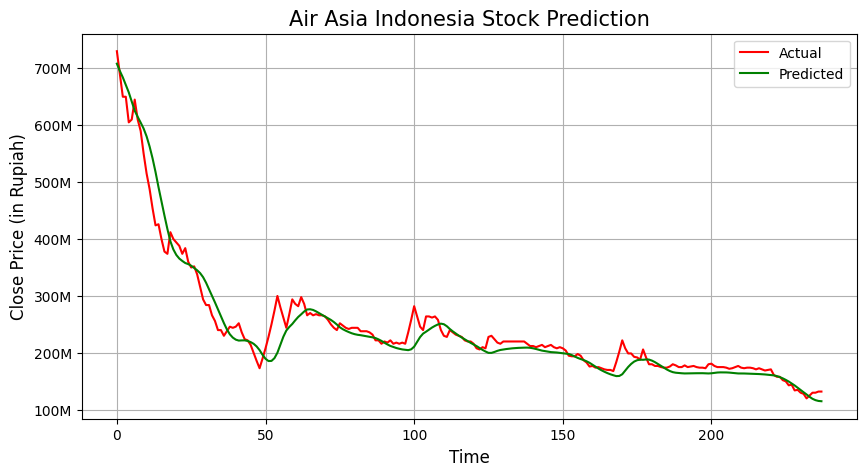

In [97]:
# Generate predictions
train_predict = model.predict(X_train)
test_predict = model.predict(X_test)
# Invert scaling for predictions
train_predict = scaler.inverse_transform(train_predict)
train_actual = scaler.inverse_transform(y_train)
test_predict = scaler.inverse_transform(test_predict)
test_actual = scaler.inverse_transform(y_test)

# Define the formatter function
def millions(x, pos):
    return '{:,.0f}M'.format(x/1e6)
# plot testing actual vs predicted values
plt.figure(figsize=(10,5))
plt.plot(test_actual, label='Actual', color='red')
plt.plot(test_predict, label='Predicted', color='green')
plt.title('Air Asia Indonesia Stock Prediction', fontsize=15)
plt.xlabel('Time', fontsize=12)
plt.ylabel('Close Price (in Rupiah)', fontsize=12)
plt.legend()
plt.grid(True)
plt.gca().yaxis.set_major_formatter(ticker.FuncFormatter(millions))
plt.show()
# Save the default model
model.save('models/cmpp_tanh_adamax.h5')

##### Comparison LSTM Model based on Activation and Optimizer Parameter

In [98]:
# Define the activation functions and optimizers to be tested
activations = ['linear', 'relu', 'tanh', 'sigmoid']
optimizers = ['adam', 'adagrad', 'nadam', 'rmsprop', 'adadelta', 'sgd', 'adamax']

# Generate all possible combinations of activation functions and optimizers
combinations = list(itertools.product(activations, optimizers))

# Define a function to build and train an LSTM model with a given activation function and optimizer
def build_model(activations, optimizers):
    model = Sequential()
    model.add(LSTM(128, input_shape=(sequence_length, num_features), return_sequences=True))
    model.add(Dropout(0.2))
    model.add(LSTM(64))
    model.add(Dropout(0.2))
    model.add(Dense(32, activation=activations))
    model.add(Dense(1))
    model.compile(loss='mean_squared_error', optimizer=optimizers)
    model.fit(X_train, y_train, batch_size=100, epochs=10, validation_split=0.1, verbose=0)
    return model

# Train and evaluate the models for all possible combinations of activation functions and optimizers
results = []
for activations, optimizers in combinations:
    print(f'Training model with {activations} activation and {optimizers} optimizer')
    start_time = time.time()
    model = build_model(activations, optimizers)
    end_time = time.time()
    preds = model.predict(X_test)
    mape = round(metrics.mean_absolute_percentage_error(y_test, preds), 5)
    mae = round(metrics.mean_absolute_error(y_test, preds), 5)
    mse = round(metrics.mean_squared_error(y_test, preds), 5)
    rmse = round(math.sqrt(mse), 5)
    r2 = round(metrics.r2_score(y_test, preds), 2)
    elapsed_time = round(end_time - start_time, 2)
    results.append([activations, optimizers, mape, mae, mse, rmse, r2, elapsed_time])

# Create a DataFrame from the results list
df_result = pd.DataFrame(results, columns=['Activation', 'Optimizer', 'MAPE (%)', 'MAE (%)', 
                                           'MSE (%)', 'RMSE (%)', 'R-Squared (%)', 'Elapsed Time (min)'])

# Create a pivot table to compare the results
df_pivot_result = pd.pivot_table(df_result, values=['MAPE (%)', 'MAE (%)', 'MSE (%)', 'RMSE (%)', 'R-Squared (%)', 'Elapsed Time (min)'], 
                                 index=['Activation', 'Optimizer'])

Training model with linear activation and adam optimizer
8/8 [==============================] - 2s 44ms/step
Training model with linear activation and adagrad optimizer
8/8 [==============================] - 2s 52ms/step
Training model with linear activation and nadam optimizer
8/8 [==============================] - 2s 63ms/step
Training model with linear activation and rmsprop optimizer
8/8 [==============================] - 2s 52ms/step
Training model with linear activation and adadelta optimizer
8/8 [==============================] - 2s 56ms/step
Training model with linear activation and sgd optimizer
8/8 [==============================] - 2s 49ms/step
Training model with linear activation and adamax optimizer
8/8 [==============================] - 2s 43ms/step
Training model with relu activation and adam optimizer
8/8 [==============================] - 2s 44ms/step
Training model with relu activation and adagrad optimizer
8/8 [==============================] - 2s 51ms/step
Training

In [99]:
# Create a DataFrame from the results list
df_result = pd.DataFrame(results, columns=['Activation', 'Optimizer', 'MAPE (%)', 'MAE (%)', 
                                           'MSE (%)', 'RMSE (%)', 'R-Squared (%)', 'Elapsed Time (min)'])

# Create a pivot table to compare the results
df_pivot_result = pd.pivot_table(df_result, values=['MAPE (%)', 'MAE (%)', 'MSE (%)', 'RMSE (%)', 'R-Squared (%)', 'Elapsed Time (min)'], 
                                 index=['Activation', 'Optimizer'])
# Get several LSTM model evaluation 
df_pivot_result.sort_values(by=['Activation', 'Optimizer'], ascending=True)

Elapsed Time (min)  MAE (%)  MAPE (%)  MSE (%)  \
Activation Optimizer                                                   
linear     adadelta               151.76  0.12679   0.90213  0.02208   
           adagrad                139.31  0.03897   0.23728  0.00470   
           adam                   150.87  0.00937   0.06572  0.00021   
           adamax                 152.27  0.00955   0.06778  0.00022   
           nadam                  160.54  0.01096   0.07189  0.00033   
           rmsprop                156.85  0.02055   0.15429  0.00064   
           sgd                    149.26  0.04410   0.27032  0.00612   
relu       adadelta               161.45  0.11606   0.83040  0.01825   
           adagrad                140.90  0.04896   0.28065  0.00722   
           adam                   138.58  0.01105   0.07398  0.00032   
           adamax                 162.31  0.01080   0.07714  0.00026   
           nadam                  154.47  0.00983   0.06767  0.00024   
           rmsprop                143.80  0.01569   0.12816  0.00038   
           sgd                    163.13  0.02922   0.18017  0.00257   
sigmoid    adadelta               165.97  0.70411   6.36782  0.50169   
           adagrad                183.57  0.84699   7.23641  0.72178   
           adam                   191.95  0.01370   0.10034  0.00036   
           adamax                 148.94  0.01477   0.11386  0.00041   
           nadam                  201.36  0.01450   0.11246  0.00035   
           rmsprop                160.48  0.01928   0.14664  0.00061   
           sgd                    162.70  0.04417   0.27106  0.00613   
tanh       adadelta               181.18  0.09756   0.69057  0.01318   
           adagrad                154.44  0.03944   0.24025  0.00480   
           adam                   148.00  0.01037   0.07313  0.00025   
           adamax                 190.11  0.01392   0.10791  0.00036   
           nadam                  168.23  0.01787   0.12848  0.00056   
           rmsprop                173.58  0.01639   0.12785  0.00046   
           sgd                    186.69  0.03447   0.21514  0.00367   

                      R-Squared (%)  RMSE (%)  
Activation Optimizer                           
linear     adadelta           -2.74   0.14859  
           adagrad             0.20   0.06856  
           adam                0.96   0.01449  
           adamax              0.96   0.01483  
           nadam               0.94   0.01817  
           rmsprop             0.89   0.02530  
           sgd                -0.04   0.07823  
relu       adadelta           -2.09   0.13509  
           adagrad            -0.22   0.08497  
           adam                0.95   0.01789  
           adamax              0.96   0.01612  
           nadam               0.96   0.01549  
           rmsprop             0.94   0.01949  
           sgd                 0.57   0.05070  
sigmoid    adadelta          -84.07   0.70830  
           adagrad          -121.38   0.84958  
           adam                0.94   0.01897  
           adamax              0.93   0.02025  
           nadam               0.94   0.01871  
           rmsprop             0.90   0.02470  
           sgd                -0.04   0.07829  
tanh       adadelta           -1.24   0.11480  
           adagrad             0.19   0.06928  
           adam                0.96   0.01581  
           adamax              0.94   0.01897  
           nadam               0.91   0.02366  
           rmsprop             0.92   0.02145  
           sgd                 0.38   0.06058

In [100]:
# Create a DataFrame from the results list
df_result = pd.DataFrame(results, columns=['Activation', 'Optimizer', 'MAPE (%)', 'MAE (%)', 
                                           'MSE (%)', 'RMSE (%)', 'R-Squared (%)', 'Elapsed Time (min)'])

# Create a pivot table to compare the results
df_pivot_result = pd.pivot_table(df_result, values=['MAPE (%)', 'MAE (%)', 'MSE (%)', 'RMSE (%)', 'R-Squared (%)', 'Elapsed Time (min)'], 
                                 index=['Activation', 'Optimizer'])

# Calculate t-statistics and p-values for each performance metric
for col in ['MAPE (%)', 'MAE (%)', 'MSE (%)', 'RMSE (%)', 'R-Squared (%)']:
    t_stat, p_val = stats.ttest_1samp(df_result[col], 0.05)
    new_col_name_tstat = '{} (t-Statistic)'.format(col)
    new_col_name_pval = '{} (p-Value)'.format(col)
    df_pivot_result[new_col_name_tstat] = round(t_stat, 5)
    df_pivot_result[new_col_name_pval] = round(p_val, 5)

# Print the resulting pivot table with the horizontal t-statistic and p-value columns
df_pivot_result.sort_values(by=['MAPE (%)', 'MAE (%)', 'MSE (%)', 'RMSE (%)', 'Elapsed Time (min)'], ascending=True)

Elapsed Time (min)  MAE (%)  MAPE (%)  MSE (%)  \
Activation Optimizer                                                   
linear     adam                   150.87  0.00937   0.06572  0.00021   
relu       nadam                  154.47  0.00983   0.06767  0.00024   
linear     adamax                 152.27  0.00955   0.06778  0.00022   
           nadam                  160.54  0.01096   0.07189  0.00033   
tanh       adam                   148.00  0.01037   0.07313  0.00025   
relu       adam                   138.58  0.01105   0.07398  0.00032   
           adamax                 162.31  0.01080   0.07714  0.00026   
sigmoid    adam                   191.95  0.01370   0.10034  0.00036   
tanh       adamax                 190.11  0.01392   0.10791  0.00036   
sigmoid    nadam                  201.36  0.01450   0.11246  0.00035   
           adamax                 148.94  0.01477   0.11386  0.00041   
tanh       rmsprop                173.58  0.01639   0.12785  0.00046   
relu       rmsprop                143.80  0.01569   0.12816  0.00038   
tanh       nadam                  168.23  0.01787   0.12848  0.00056   
sigmoid    rmsprop                160.48  0.01928   0.14664  0.00061   
linear     rmsprop                156.85  0.02055   0.15429  0.00064   
relu       sgd                    163.13  0.02922   0.18017  0.00257   
tanh       sgd                    186.69  0.03447   0.21514  0.00367   
linear     adagrad                139.31  0.03897   0.23728  0.00470   
tanh       adagrad                154.44  0.03944   0.24025  0.00480   
linear     sgd                    149.26  0.04410   0.27032  0.00612   
sigmoid    sgd                    162.70  0.04417   0.27106  0.00613   
relu       adagrad                140.90  0.04896   0.28065  0.00722   
tanh       adadelta               181.18  0.09756   0.69057  0.01318   
relu       adadelta               161.45  0.11606   0.83040  0.01825   
linear     adadelta               151.76  0.12679   0.90213  0.02208   
sigmoid    adadelta               165.97  0.70411   6.36782  0.50169   
           adagrad                183.57  0.84699   7.23641  0.72178   

                      R-Squared (%)  RMSE (%)  MAPE (%) (t-Statistic)  \
Activation Optimizer                                                    
linear     adam                0.96   0.01449                 1.94382   
relu       nadam               0.96   0.01549                 1.94382   
linear     adamax              0.96   0.01483                 1.94382   
           nadam               0.94   0.01817                 1.94382   
tanh       adam                0.96   0.01581                 1.94382   
relu       adam                0.95   0.01789                 1.94382   
           adamax              0.96   0.01612                 1.94382   
sigmoid    adam                0.94   0.01897                 1.94382   
tanh       adamax              0.94   0.01897                 1.94382   
sigmoid    nadam               0.94   0.01871                 1.94382   
           adamax              0.93   0.02025                 1.94382   
tanh       rmsprop             0.92   0.02145                 1.94382   
relu       rmsprop             0.94   0.01949                 1.94382   
tanh       nadam               0.91   0.02366                 1.94382   
sigmoid    rmsprop             0.90   0.02470                 1.94382   
linear     rmsprop             0.89   0.02530                 1.94382   
relu       sgd                 0.57   0.05070                 1.94382   
tanh       sgd                 0.38   0.06058                 1.94382   
linear     adagrad             0.20   0.06856                 1.94382   
tanh       adagrad             0.19   0.06928                 1.94382   
linear     sgd                -0.04   0.07823                 1.94382   
sigmoid    sgd                -0.04   0.07829                 1.94382   
relu       adagrad            -0.22   0.08497                 1.94382   
tanh       adadelta           -1.24 

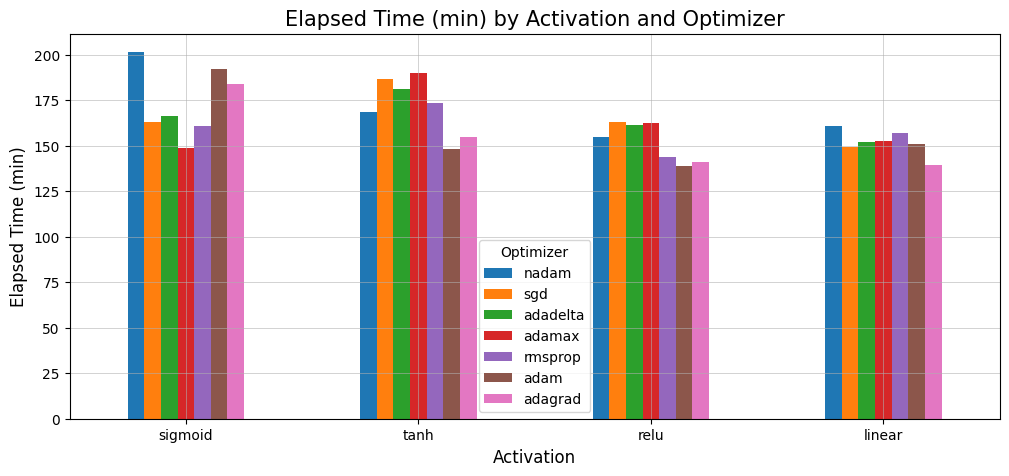

In [101]:
# Pivot the DataFrame to create a table with optimizer as columns and activation as rows
df_time = df_result.pivot_table(index='Activation', columns='Optimizer', values='Elapsed Time (min)')
# Sort the columns based on the mean elapsed time value
df_time = df_time[df_time.mean().sort_values(ascending=False).index]
# Sort the rows based on the activation function
df_time = df_time.sort_index(ascending=True)
# Sort the values in the x-axis in descending order based on the highest mean elapsed time value
df_time = df_time.sort_values(by=df_time.columns[-1], ascending=False)

# Create the bar chart
fig, ax = plt.subplots(figsize=(12,5))
df_time.plot(kind='bar', ax=ax)
ax.set_xlabel('Activation', fontsize=12)
ax.set_ylabel('Elapsed Time (min)', fontsize=12)
ax.set_title('Elapsed Time (min) by Activation and Optimizer', fontsize=15)
# formatter = ticker.PercentFormatter(xmax=1, decimals=0)
# ax.yaxis.set_major_formatter(formatter)
ax.grid(True, linewidth='0.4')
ax.set_xticklabels(ax.get_xticklabels(), rotation=0)
plt.show()

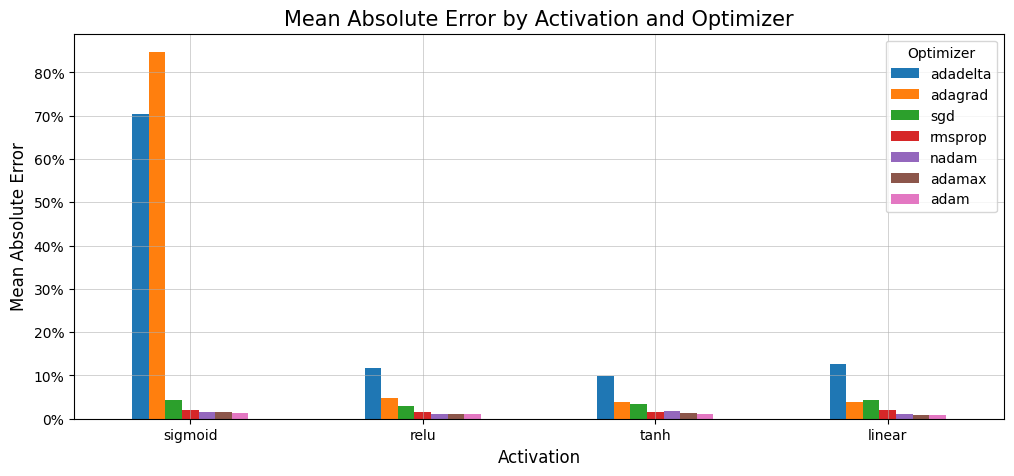

In [102]:
# Pivot the DataFrame to create a table with optimizer as columns and activation as rows
df_mae = df_result.pivot_table(index='Activation', columns='Optimizer', values='MAE (%)')
# Sort the columns based on the mean MAE value
df_mae = df_mae[df_mae.mean().sort_values(ascending=False).index]
# Sort the rows based on the activation function
df_mae = df_mae.sort_index(ascending=True)
# Sort the values in the x-axis in descending order based on the highest mean MAE value
df_mae = df_mae.sort_values(by=df_mae.columns[-1], ascending=False)

# Create the bar chart
fig, ax = plt.subplots(figsize=(12,5))
df_mae.plot(kind='bar', ax=ax)
ax.set_xlabel('Activation', fontsize=12)
ax.set_ylabel('Mean Absolute Error', fontsize=12)
ax.set_title('Mean Absolute Error by Activation and Optimizer', fontsize=15)
formatter = ticker.PercentFormatter(xmax=1, decimals=0)
ax.yaxis.set_major_formatter(formatter)
ax.grid(True, linewidth='0.4')
ax.set_xticklabels(ax.get_xticklabels(), rotation=0)
# ax.legend(loc='upper right', bbox_to_anchor=(1.14, 1.02))
plt.show()

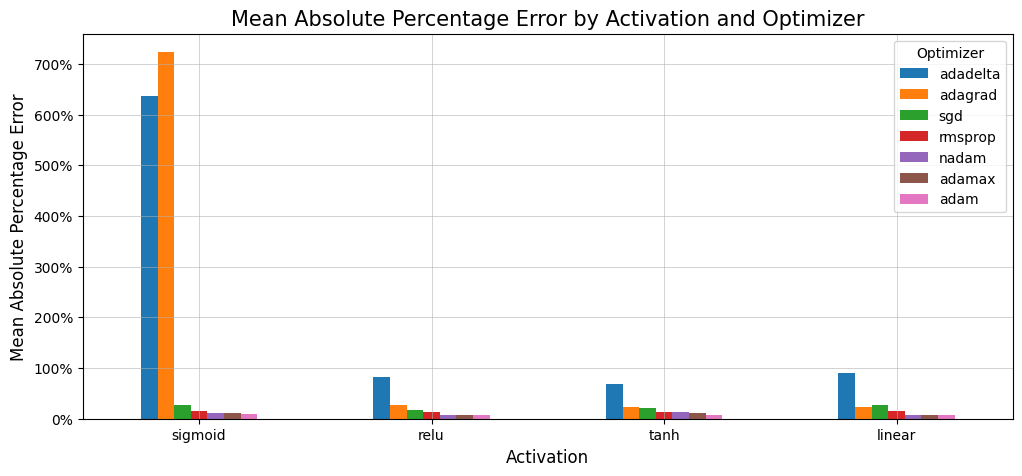

In [103]:
# Pivot the DataFrame to create a table with optimizer as columns and activation as rows
df_mape = df_result.pivot_table(index='Activation', columns='Optimizer', values='MAPE (%)')
# Sort the columns based on the mean MAPE value
df_mape = df_mape[df_mae.mean().sort_values(ascending=False).index]
# Sort the rows based on the activation function
df_mape = df_mape.sort_index(ascending=True)
# Sort the values in the x-axis in descending order based on the highest mean MAPE value
df_mape = df_mape.sort_values(by=df_mape.columns[-1], ascending=False)

# Create the bar chart
fig, ax = plt.subplots(figsize=(12,5))
df_mape.plot(kind='bar', ax=ax)
ax.set_xlabel('Activation', fontsize=12)
ax.set_ylabel('Mean Absolute Percentage Error', fontsize=12)
ax.set_title('Mean Absolute Percentage Error by Activation and Optimizer', fontsize=15)
formatter = ticker.PercentFormatter(xmax=1, decimals=0)
ax.yaxis.set_major_formatter(formatter)
ax.grid(True, linewidth='0.4')
ax.set_xticklabels(ax.get_xticklabels(), rotation=0)
# ax.legend(loc='upper right', bbox_to_anchor=(1.14, 1.02))
plt.show()

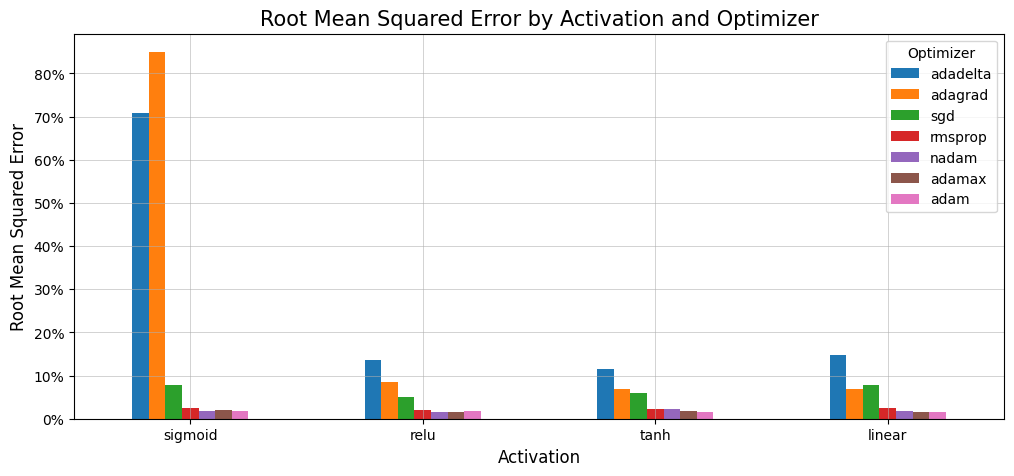

In [104]:
# Pivot the DataFrame to create a table with optimizer as columns and activation as rows
df_rmse = df_result.pivot_table(index='Activation', columns='Optimizer', values='RMSE (%)')
# Sort the columns based on the mean RMSE value
df_rmse = df_rmse[df_rmse.mean().sort_values(ascending=False).index]
# Sort the rows based on the activation function
df_rmse = df_rmse.sort_index(ascending=True)
# Sort the values in the x-axis in descending order based on the highest mean RMSE value
df_rmse = df_rmse.sort_values(by=df_rmse.columns[-1], ascending=False)

# Create the bar chart
fig, ax = plt.subplots(figsize=(12,5))
df_rmse.plot(kind='bar', ax=ax)
ax.set_xlabel('Activation', fontsize=12)
ax.set_ylabel('Root Mean Squared Error', fontsize=12)
ax.set_title('Root Mean Squared Error by Activation and Optimizer', fontsize=15)
formatter = ticker.PercentFormatter(xmax=1, decimals=0)
ax.yaxis.set_major_formatter(formatter)
ax.grid(True, linewidth='0.4')
ax.set_xticklabels(ax.get_xticklabels(), rotation=0)
# ax.legend(loc='upper right', bbox_to_anchor=(1.14, 1.02))
plt.show()

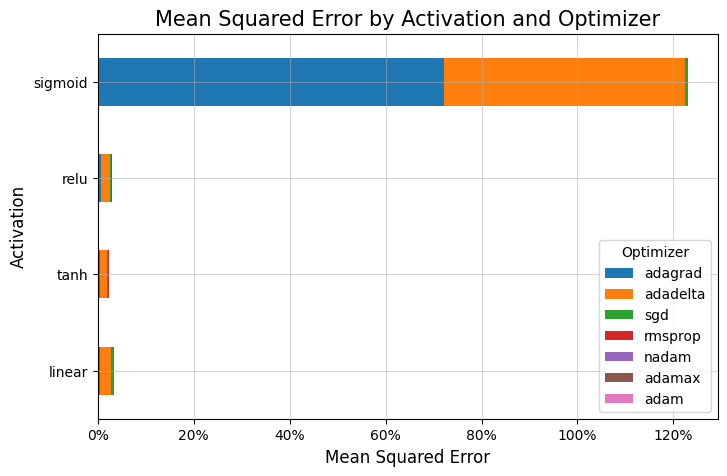

In [105]:
# Pivot the DataFrame to create a table with optimizer as columns and activation as rows
df_mse = df_result.pivot_table(index='Activation', columns='Optimizer', values='MSE (%)')
# Sort the columns based on the mean MSE value
df_mse = df_mse[df_mse.mean().sort_values(ascending=False).index]
# Sort the rows based on the activation function
df_mse = df_mse.sort_index(ascending=True)
# Sort the values in the x-axis in descending order based on the highest mean MSE value
df_mse = df_mse.sort_values(by=df_mse.columns[-1], ascending=True)

# Create the stacked bar chart
fig, ax = plt.subplots(figsize=(8,5))
df_mse.plot(kind='barh', stacked=True, ax=ax) # modified line
ax.set_xlabel('Mean Squared Error', fontsize=12)
ax.set_ylabel('Activation', fontsize=12) # modified line
ax.set_title('Mean Squared Error by Activation and Optimizer', fontsize=15)
formatter = ticker.PercentFormatter(xmax=1, decimals=0)
ax.xaxis.set_major_formatter(formatter) # modified line
ax.grid(True, linewidth='0.4')
ax.set_yticklabels(ax.get_yticklabels(), rotation=0) # modified line
# ax.legend(loc='upper right', bbox_to_anchor=(1.14, 1.02))
plt.show()

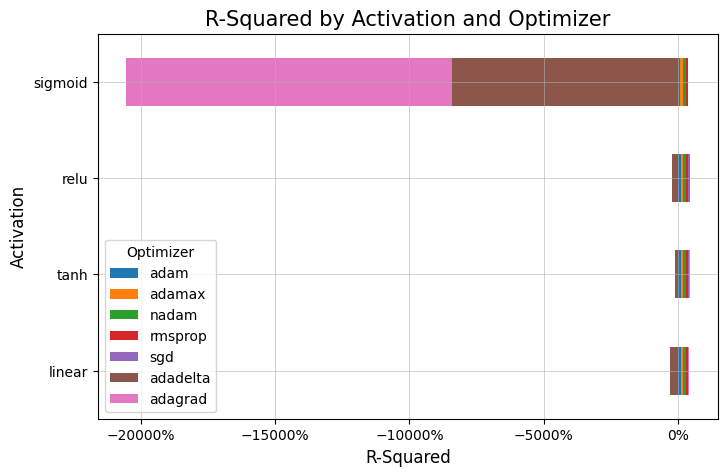

In [106]:
# Pivot the DataFrame to create a table with optimizer as columns and activation as rows
df_r2 = df_result.pivot_table(index='Activation', columns='Optimizer', values='R-Squared (%)')
# Sort the columns based on the mean R2 value
df_r2 = df_r2[df_r2.mean().sort_values(ascending=False).index]
# Sort the rows based on the activation function
df_r2 = df_r2.sort_index(ascending=True)
# Sort the values in the x-axis in descending order based on the highest mean R2 value
df_r2 = df_r2.sort_values(by=df_rmse.columns[-1], ascending=False)

# Create the bar chart
fig, ax = plt.subplots(figsize=(8,5))
df_r2.plot(kind='barh', stacked=True, ax=ax)
ax.set_xlabel('R-Squared', fontsize=12)
ax.set_ylabel('Activation', fontsize=12)
ax.set_title('R-Squared by Activation and Optimizer', fontsize=15)
formatter = ticker.PercentFormatter(xmax=1, decimals=0)
ax.xaxis.set_major_formatter(formatter)
ax.grid(True, linewidth='0.4')
ax.set_xticklabels(ax.get_xticklabels(), rotation=0)
# ax.legend(loc='upper right', bbox_to_anchor=(1.14, 1.02))
plt.show()